## Sentiment analysis on twitter 2020 election data

The 2020 US election is happening on the 3rd November 2020, today as of writing this kernel, and the resulting impact to the world will no doubt be large, irrespective of which candidate is elected! After reading the two papers, [here](https://arxiv.org/abs/1706.02271) and [here](https://dl.acm.org/doi/fullHtml/10.1145/3339909), I was inspired to attempt a similar sentiment analysis myself!

However before I could do this I had to create a [dataset](https://www.kaggle.com/manchunhui/us-election-2020-tweets) first! Please feel free to download and use at your pleasure, the intention is to obtain data upto the end of the 4th of Nov. With regards to the dataset, ot contains two .csv files containing tweets obtained using snsscrape, keywords #JoeBiden, #DonaldTrump, ,#Biden #Trump with the Twitter API.


## Chapter 1: Exploratory Data Analysis
Before we jump into the sentiment analysis, lets carry some exploration of the dataset! You can view preliminary EDA at this [link](https://www.kaggle.com/manchunhui/starter-kernel-us-election-2020-tweets-prelim-eda), I will not be running over the same details in here. I've decided to hide some of the visualisation code as it distracts from the flow of the analysis, please click on the buttons to view the code if you wish.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install langdetect

In [3]:
# Import Libraries
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
zip_pass = '/content/drive/MyDrive/archive.zip'

import zipfile
zip_f = zipfile.ZipFile(zip_pass)
file_list = zip_f.namelist()
file_list

['hashtag_donaldtrump.csv', 'hashtag_joebiden.csv']

In [5]:
# Reading both the csv files
tweets_biden = pd.read_csv(zip_f.open(file_list[1]), lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv(zip_f.open(file_list[0]), lineterminator='\n', parse_dates=True)

# Clean data
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])

In [6]:
tweets_biden['collected_at']=tweets_biden['collected_at'].apply(lambda x: x[:19])
tweets_trump['collected_at']=tweets_trump['collected_at'].apply(lambda x: x[:19])

In [7]:
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

In [8]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

<ipython-input-8-a5ebd449a980>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)


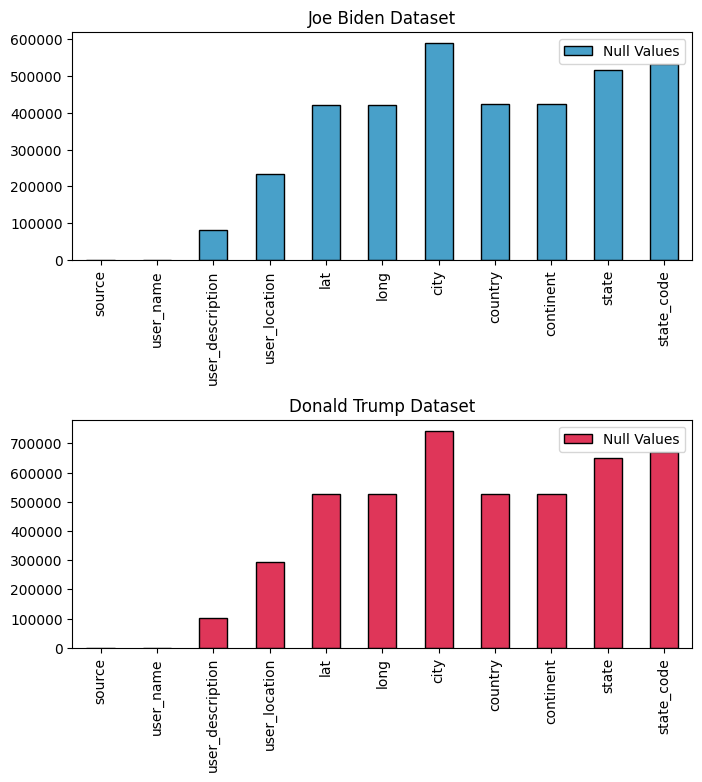

In [9]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

Geo spatial features ***```lat, long, city, country, continent, state state code```*** were all derived from ***```user_location```***, using ***sciSpacy NER*** and ***OpenCage API***. It should be noted due a number of factors (such as erroneous ***```user_location```*** inputs, my methods of deriving useful data from subject erroneous inputs and its impact on ***OpenCage API*** returned results), the geo spatial features should be used with caution!

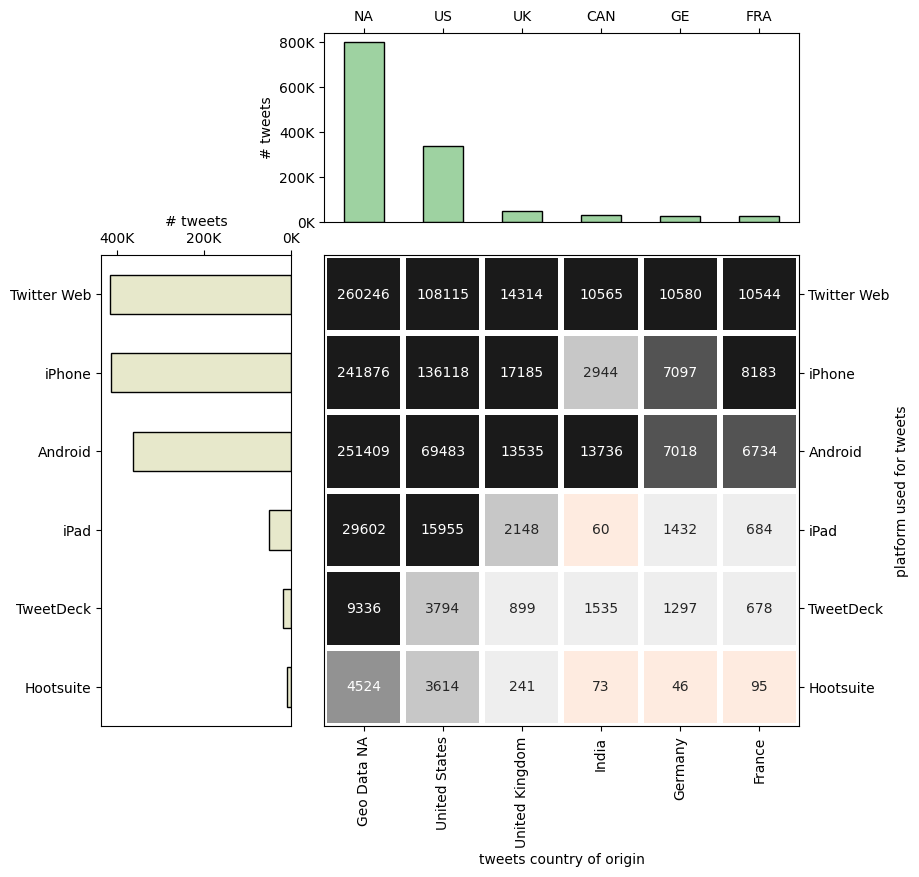

In [10]:
source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0)

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0)
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0)
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

First of all I must acknowledge that I unashamedly borrowed this heatmap design from @tkubacka, shown in her excellent [kernel](https://www.kaggle.com/tkubacka/a-story-told-through-a-heatmap), as it great at displaying a lot of information in compact space!

From the above heatmap we can see that most tweets, in the two .csv files, are published from ***```Twitter Web, Twitter iPhone, Twitter Android or Twitter iPad```*** with most of these from the US or an unidentified location.

In [11]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point, Polygon
crs = {'init': 'EPSG:4326'}

tmp=pd.concat([tweets_biden[['lat','long']].copy(),tweets_trump[['lat','long']].copy()])
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)

<ipython-input-11-87f12ceb60df>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


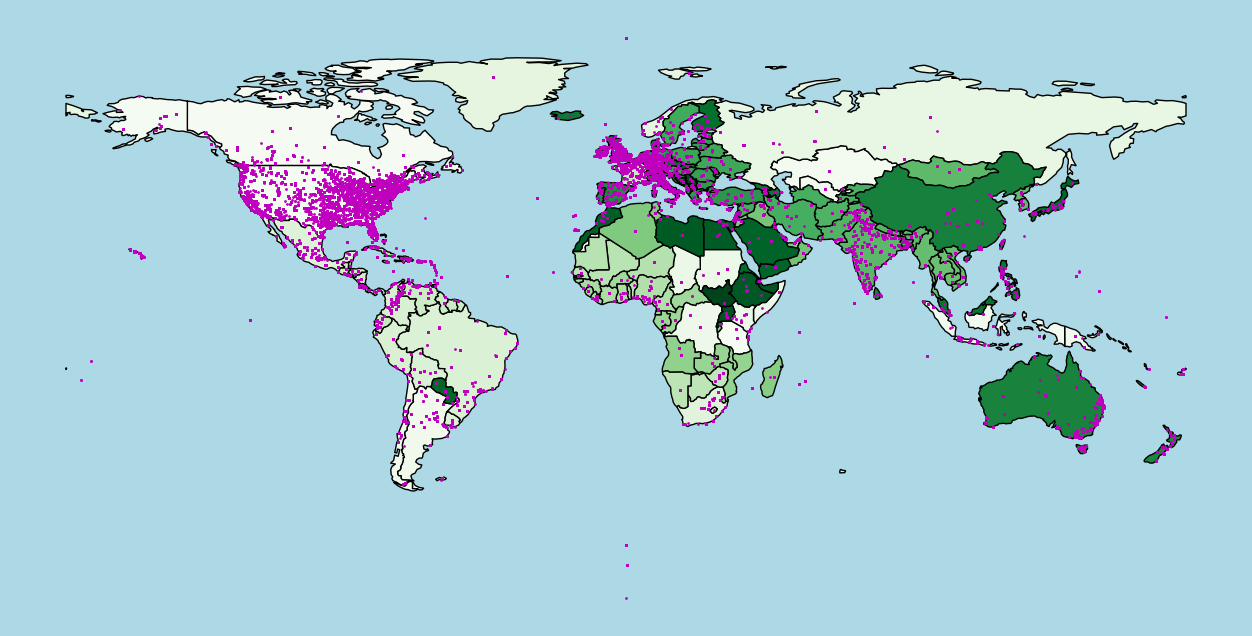

In [12]:
fig, ax = plt.subplots(1,figsize=(16,8), facecolor='lightblue')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, cmap='Greens', edgecolors='black')
geo_df.plot(ax=ax, markersize=1, color='m', marker='o')
ax.axis('off')
plt.show()

Plotting all the available geo data shows that many countries around the world are tweeting about the two presidential candidates.

In [13]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 44.4 s, sys: 372 ms, total: 44.8 s
Wall time: 46.3 s


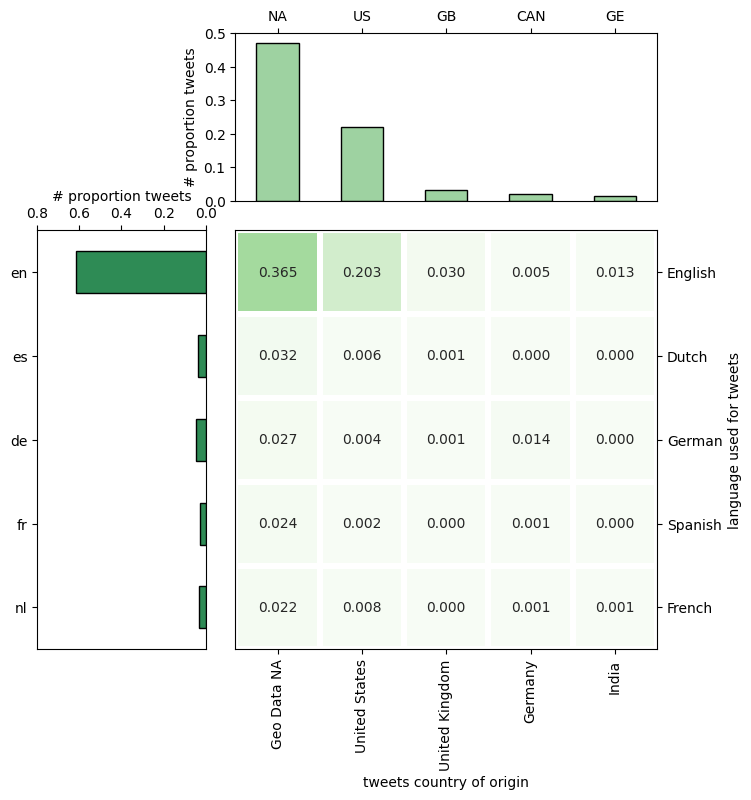

In [14]:
fig, ax=plt.subplots(2,2, figsize=(8,8),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE'), rotation=0)
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0)

plt.show()

Wanting to understand the langauges used to tweet, I used the ***```langdetect```*** function to sample 4000 tweets (which should be sufficient to provide a 99% confidence level with 1-2% margin of error for population of upto 900k tweets). The heatmap above only illustrates the top 5 languages used and the top 5 countries that they were tweeted from, in all 40 languages were detected with English accounting for almost 80% of the tweets.

In [15]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)

<ipython-input-15-09037d03b265>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df['usertype'] = 'Both'


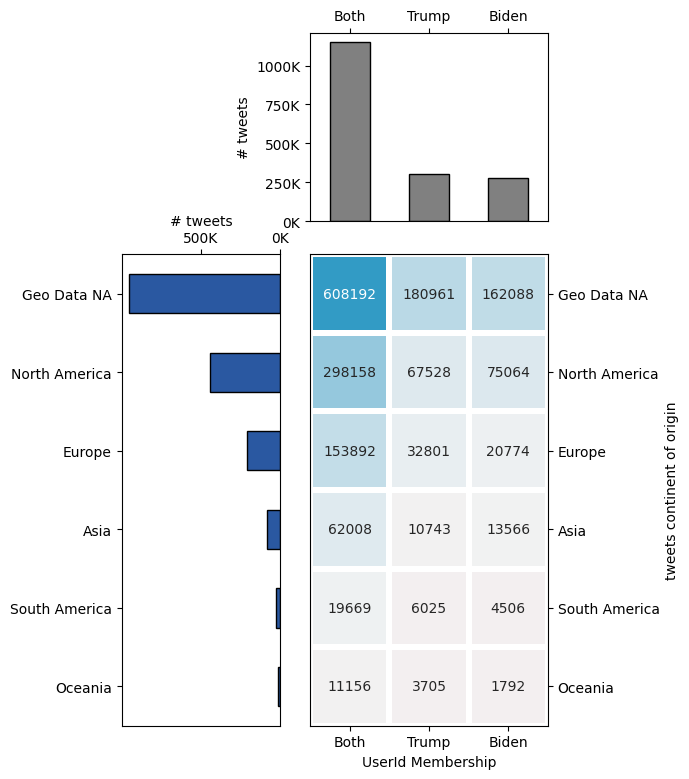

In [16]:
fig, ax=plt.subplots(2,2, figsize=(5.5,9),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,3], 'wspace':0.15, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap3(contXtab.loc[contlst,userlst], hm_ax)
hm_ax.set_xlabel('UserId Membership')
hm_ax.set_ylabel('tweets continent of origin')

bar_ax = ax[0,1]
contXtab.loc[contlst,userlst].sum().plot.bar(ax=bar_ax, color=barcolors[7],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_ylabel('# tweets')
bar_ax.set_xlabel('')

barh_ax = ax[1,0]
contXtab.loc[contlst,userlst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[4],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')

plt.show()

UserId's that post about both presidential candidates post the most, accounting for greater than 60% of the tweets. Furthermore as with the heatmaps above most tweets are from the America, at least the tweets that have geo data.

In [17]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

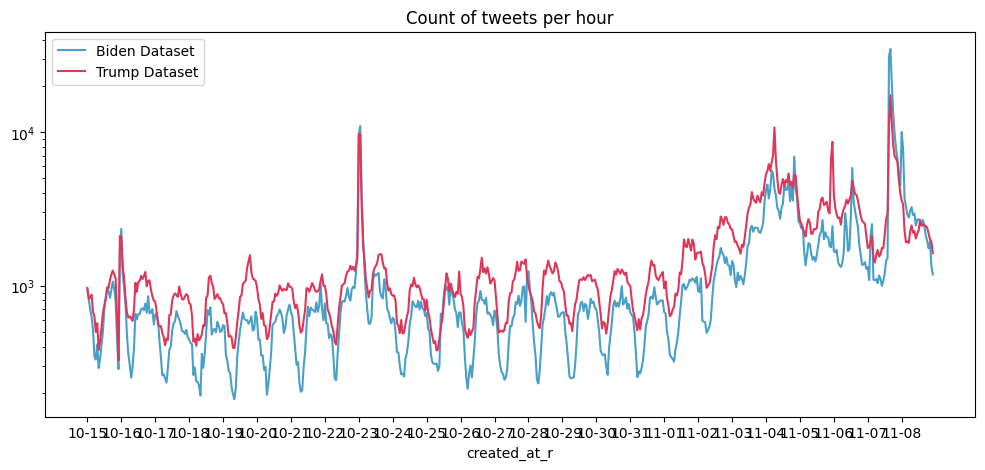

In [18]:
plt.figure(figsize=(12,5))
p6=sns.lineplot(x=cnt_tbiden.index, y=cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
p6.set_title('Count of tweets per hour')
p6=sns.lineplot(x=cnt_ttrump.index, y=cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

#### Updated 5th Nov - Version 28
Tweets about both presidential candidates have been fairly stable in terms of tweets per hour and pattern regularity, with notable exceptions on the date of the last presidential debate and as we come up to and on the election date. On the election date itself there is large notable changes in the pattern regularity on both datasets, with an steady increasing trend in tweet volume for the both of the presidential candidates.

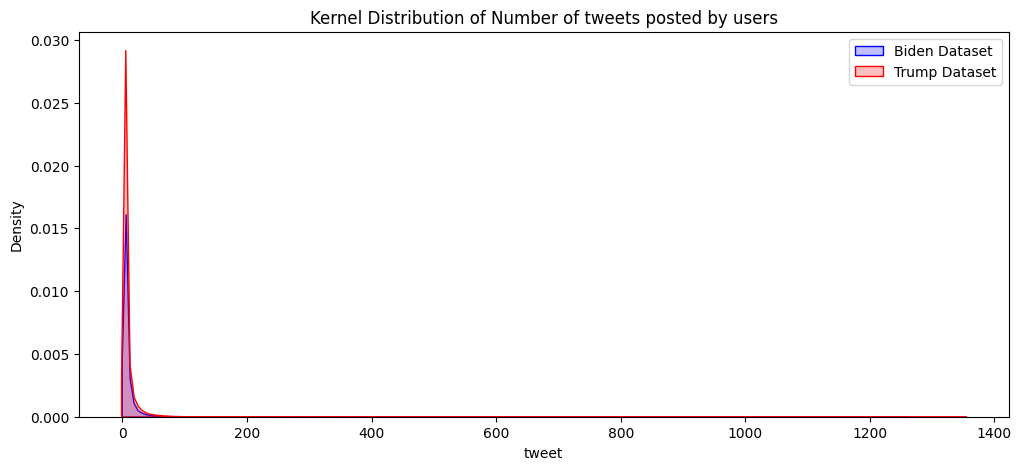

In [19]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Number of tweets posted by users')
sns.kdeplot(tweets_biden.groupby(['user_id'])['tweet'].count(), fill=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), fill=True, color='r', label='Trump Dataset', ax=line_ax)
plt.legend()
plt.show()

The kernel distribution shows that users in both datasets have similar posting frequencies, with a small number of users in the "Biden" dataset posting more than a 1000 tweets.

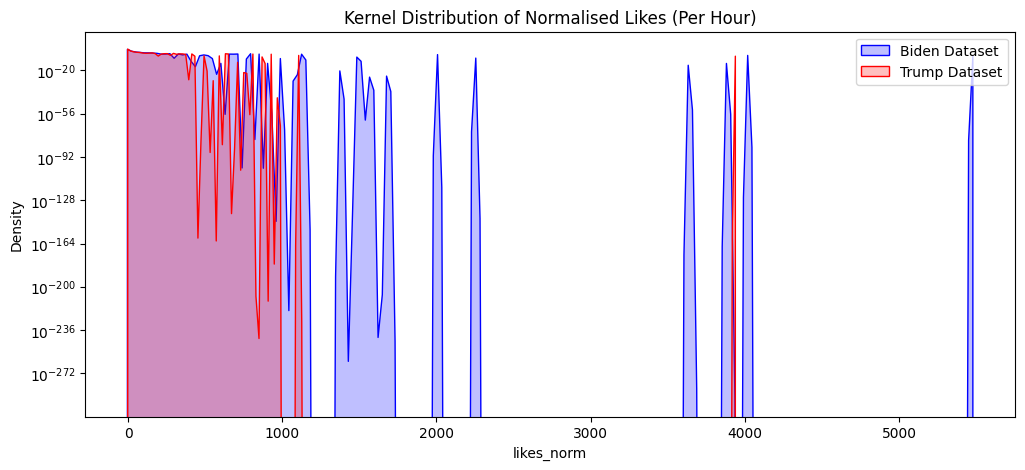

In [20]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Likes (Per Hour)')
sns.kdeplot(tweets_biden['likes_norm'],bw_method=0.1, fill=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'],bw_method=0.1, fill=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.legend()
plt.show()

The y-axis is using a log scale to extract more detail from both the tweet and retweet visualisations.

Additionally both the ***```likes```*** and ***```retweets```*** have been normalised to ***```likes```*** and ***```retweets```*** per hour to try to account for the difference in time from the creation of each tweet and the time of collecting the data.

The "Biden" dataset shows small but persistant number of tweets with higher normalised "Likes" than in the "Trump" dataset.

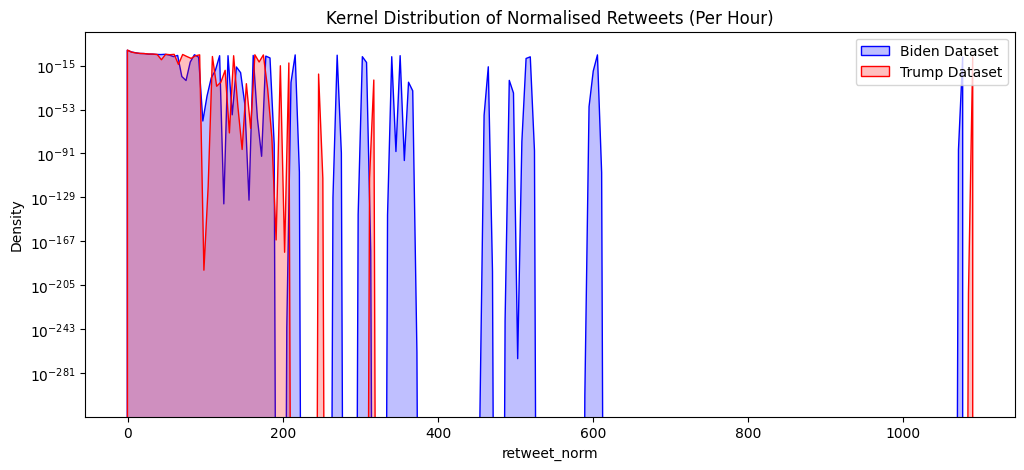

In [21]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Retweets (Per Hour)')
sns.kdeplot(tweets_biden['retweet_norm'],bw_method=0.1, fill=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['retweet_norm'],bw_method=0.1, fill=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.legend()
plt.show()

The "Biden" dataset, similar to the previous visualisation, shows small but persistant number of tweets with higher normalised "retweets" than seen in the "Trump" dataset..

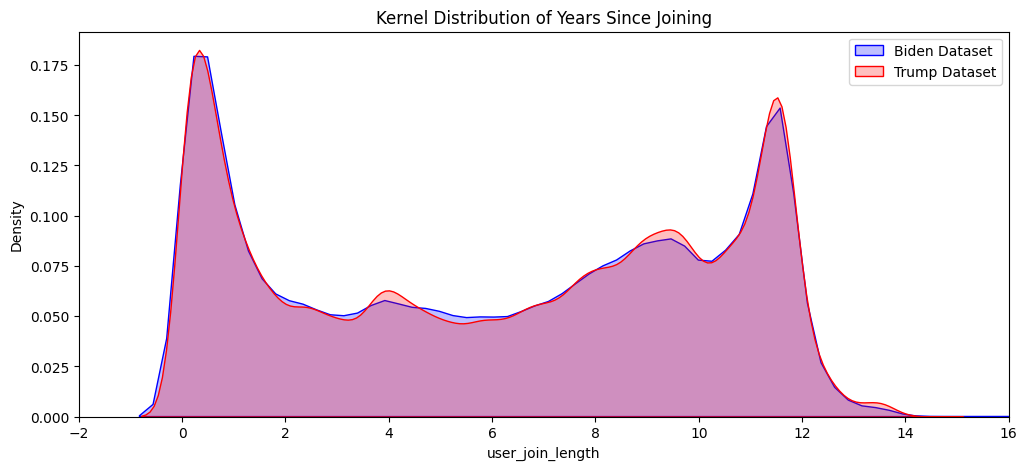

In [22]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
tweets_biden['user_join_length'] = max(tweets_biden['created_at']) - tweets_biden['user_join_date']
tweets_trump['user_join_length'] = max(tweets_trump['created_at']) - tweets_trump['user_join_date']

line_ax = ax
plt.xlim(-2, 16)
line_ax.set_title('Kernel Distribution of Years Since Joining')
sns.kdeplot(tweets_biden['user_join_length'].dt.days/365.25, fill=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['user_join_length'].dt.days/365.25, fill=True, color='r', label='Trump Dataset', ax=line_ax)
plt.legend()
plt.show()

In terms of years since joiner for users, both dataset have a similar distribution with a peak at 12 years and another peak showing users joining twitter to tweet about each of the respective presidential candidates.

## Chapter 2: N-grams and Sentiment Analysis (VADAR)

In second and last part of this kernel I will perform Sentiment Analysis on each of the datasets respectively to ascertain the overall sentiment. To perform the Sentiment Analysis I will be using VADER (Valence Aware Dictionary and sEntiment Reasoner) package, which is a lexicon and rule-based sentiment analysis tool that is specifically tuned to sentiments expressed in social media! Perfect for my use case.

In [23]:
# Obtain tweets only from data that has Geo Data from the US
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

Before the N-gram analysis we first must clean the tweets to remove stopwords, strings with "http" etc and then lemmatize the words.

In [24]:
# import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

In [27]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

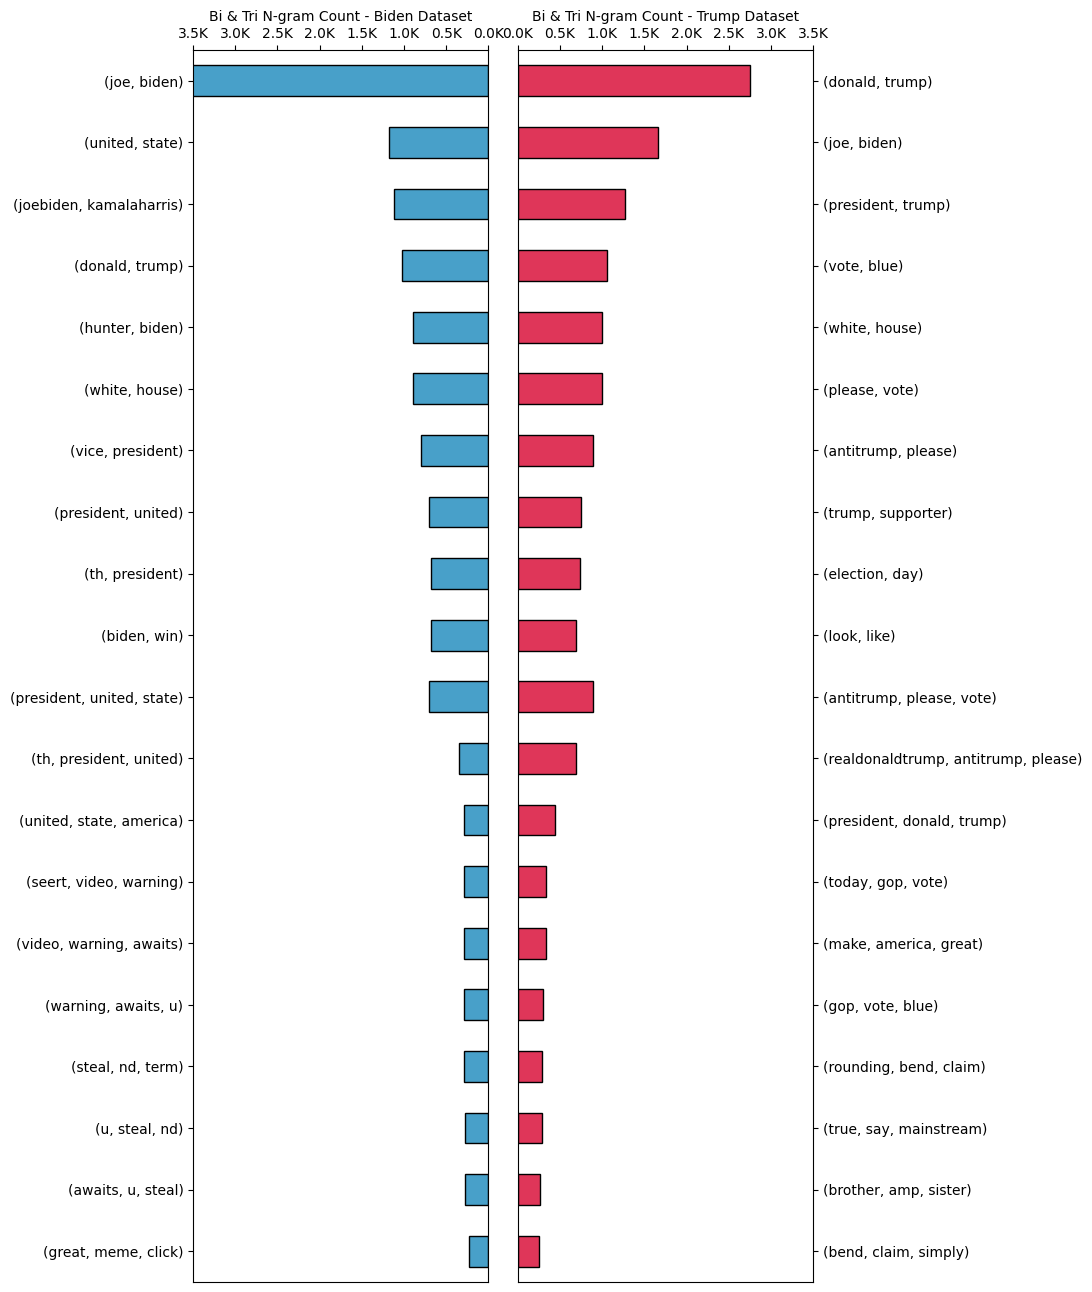

In [28]:
fig, ax=plt.subplots(1,2, figsize=(8,16),
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Dataset')
barh_ax.set_ylabel('')
plt.show()

The above bar chart shows the most common Bi and Tri N-gram's in each of the respective datasets, filtered from words just from the "United States of America". The N-gram's show a clear relation to the upcoming election and each respective dataset seems to be related to each of the presidential candidates.

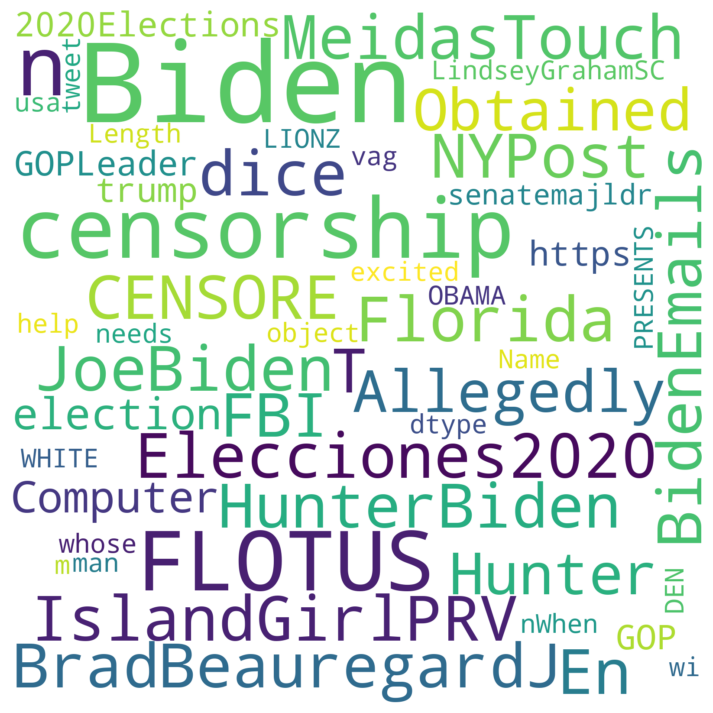

In [29]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS,
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

Wordcloud created just from the "Biden" dataset, if I am honest I cannot gain much information from this.

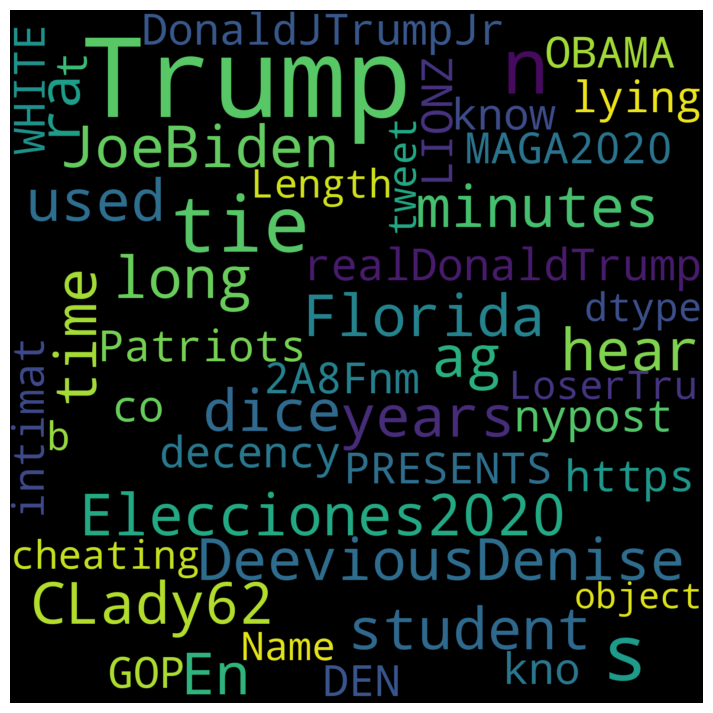

In [30]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS,
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()

Wordcloud created just from the "Trump" dataset, similarly to the above wordcloud I cannot ascertain much information from this.

In [31]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
# Obtain sentiment scores for both datasets
sid = SentimentIntensityAnalyzer()
tweets_biden['VADAR']=sentiment(tweets_biden['tweet'])
tweets_trump['VADAR']=sentiment(tweets_trump['tweet'])
tweets_biden['compound']  = tweets_biden['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['compound']  = tweets_trump['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['sentiment']  = tweets_trump['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))
tweets_biden['sentiment']  = tweets_biden['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))



In [33]:
# Create 52 state set
states=set(tweets_biden.loc[tweets_biden['country'] == 'United States of America']['state'].dropna())
# states.remove('District of Columbia')
states.remove('Puerto Rico')
states.remove('Northern Mariana Islands')
states.remove('Guam')

# Create feature to allow masking of data and then mask data for votable states
tweets_biden['voting_rights']=tweets_biden['state'].apply(lambda x: 'Yes' if x in states else 'No')
tweets_trump['voting_rights']=tweets_trump['state'].apply(lambda x: 'Yes' if x in states else 'No')
sent_t=tweets_trump.loc[tweets_trump['voting_rights'] == 'Yes']
sent_b=tweets_biden.loc[tweets_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 14 days
state_b=sent_b.loc[sent_b['created_at'] > max(sent_b['created_at']) - timedelta(14)]
state_t=sent_t.loc[sent_t['created_at'] > max(sent_t['created_at']) - timedelta(14)]
state_b_mean=state_b.groupby('state')['compound'].mean().reset_index()
state_t_mean=state_t.groupby('state')['compound'].mean().reset_index()

# Further mask data for only the <<first>> 14 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(14)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(14)]
state_bp_mean=state_bp.groupby('state')['compound'].mean().reset_index()
state_tp_mean=state_tp.groupby('state')['compound'].mean().reset_index()

# Create dataframe for visualisation
states_sent=pd.DataFrame({'state':state_b_mean['state'],
                          'biden1':state_b_mean['compound'],
                          'trump1':state_t_mean['compound'],
                          'biden2':state_bp_mean['compound'],
                          'trump2':state_tp_mean['compound'],})

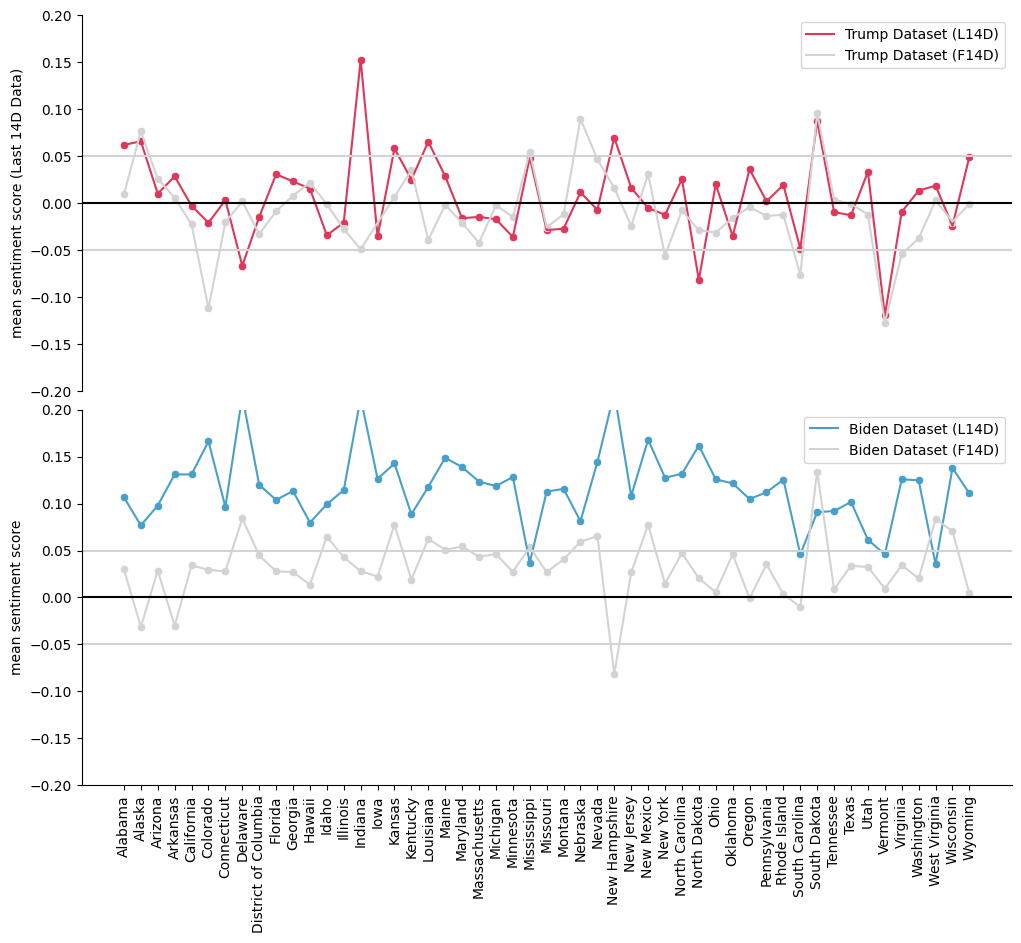

In [34]:
fig, ax=plt.subplots(2,1, figsize=(12,10), gridspec_kw={'hspace':0.05})
lineax=ax[0]
sns.lineplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax, label='Trump Dataset (L14D)')
sns.scatterplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax, label='Trump Dataset (F14D)')
sns.scatterplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score (Last 14D Data)')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax=ax[1]
sns.lineplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax, label='Biden Dataset (L14D)')
sns.scatterplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax, label='Biden Dataset (F14D)')
sns.scatterplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
plt.show()

#### Updated 4th Nov - Version 26
The VADAR analysis produces a compound sentiment score, to create the visualisation I took the mean compound score for the most recent 14 days (Labelled L14D on the charts) and the first 14 days (Labelled F14D and light grey on the charts ) for each state.

It should be noted that any sentiment score between 0.05 and -0.05 is considered "Neutral".

The results seems to show a large number of states are trending to a “Positive”  sentiment score for the democratic candidate from the previous more “Neutral” sentiment. Whereas most states are still largely "Neutral" for the republican candidate.

In [35]:
#元データに'2020-10-15 22',が欠けていたので作成
created_at_rs = pd.DataFrame({'created_at_r':['2020-10-15 00',
 '2020-10-15 01',
 '2020-10-15 02',
 '2020-10-15 03',
 '2020-10-15 04',
 '2020-10-15 05',
 '2020-10-15 06',
 '2020-10-15 07',
 '2020-10-15 08',
 '2020-10-15 09',
 '2020-10-15 10',
 '2020-10-15 11',
 '2020-10-15 12',
 '2020-10-15 13',
 '2020-10-15 14',
 '2020-10-15 15',
 '2020-10-15 16',
 '2020-10-15 17',
 '2020-10-15 18',
 '2020-10-15 19',
 '2020-10-15 20',
 '2020-10-15 21',
 '2020-10-15 22',
 '2020-10-15 23',
 '2020-10-16 00',
 '2020-10-16 01',
 '2020-10-16 02',
 '2020-10-16 03',
 '2020-10-16 04',
 '2020-10-16 05',
 '2020-10-16 06',
 '2020-10-16 07',
 '2020-10-16 08',
 '2020-10-16 09',
 '2020-10-16 10',
 '2020-10-16 11',
 '2020-10-16 12',
 '2020-10-16 13',
 '2020-10-16 14',
 '2020-10-16 15',
 '2020-10-16 16',
 '2020-10-16 17',
 '2020-10-16 18',
 '2020-10-16 19',
 '2020-10-16 20',
 '2020-10-16 21',
 '2020-10-16 22',
 '2020-10-16 23',
 '2020-10-17 00',
 '2020-10-17 01',
 '2020-10-17 02',
 '2020-10-17 03',
 '2020-10-17 04',
 '2020-10-17 05',
 '2020-10-17 06',
 '2020-10-17 07',
 '2020-10-17 08',
 '2020-10-17 09',
 '2020-10-17 10',
 '2020-10-17 11',
 '2020-10-17 12',
 '2020-10-17 13',
 '2020-10-17 14',
 '2020-10-17 15',
 '2020-10-17 16',
 '2020-10-17 17',
 '2020-10-17 18',
 '2020-10-17 19',
 '2020-10-17 20',
 '2020-10-17 21',
 '2020-10-17 22',
 '2020-10-17 23',
 '2020-10-18 00',
 '2020-10-18 01',
 '2020-10-18 02',
 '2020-10-18 03',
 '2020-10-18 04',
 '2020-10-18 05',
 '2020-10-18 06',
 '2020-10-18 07',
 '2020-10-18 08',
 '2020-10-18 09',
 '2020-10-18 10',
 '2020-10-18 11',
 '2020-10-18 12',
 '2020-10-18 13',
 '2020-10-18 14',
 '2020-10-18 15',
 '2020-10-18 16',
 '2020-10-18 17',
 '2020-10-18 18',
 '2020-10-18 19',
 '2020-10-18 20',
 '2020-10-18 21',
 '2020-10-18 22',
 '2020-10-18 23',
 '2020-10-19 00',
 '2020-10-19 01',
 '2020-10-19 02',
 '2020-10-19 03',
 '2020-10-19 04',
 '2020-10-19 05',
 '2020-10-19 06',
 '2020-10-19 07',
 '2020-10-19 08',
 '2020-10-19 09',
 '2020-10-19 10',
 '2020-10-19 11',
 '2020-10-19 12',
 '2020-10-19 13',
 '2020-10-19 14',
 '2020-10-19 15',
 '2020-10-19 16',
 '2020-10-19 17',
 '2020-10-19 18',
 '2020-10-19 19',
 '2020-10-19 20',
 '2020-10-19 21',
 '2020-10-19 22',
 '2020-10-19 23',
 '2020-10-20 00',
 '2020-10-20 01',
 '2020-10-20 02',
 '2020-10-20 03',
 '2020-10-20 04',
 '2020-10-20 05',
 '2020-10-20 06',
 '2020-10-20 07',
 '2020-10-20 08',
 '2020-10-20 09',
 '2020-10-20 10',
 '2020-10-20 11',
 '2020-10-20 12',
 '2020-10-20 13',
 '2020-10-20 14',
 '2020-10-20 15',
 '2020-10-20 16',
 '2020-10-20 17',
 '2020-10-20 18',
 '2020-10-20 19',
 '2020-10-20 20',
 '2020-10-20 21',
 '2020-10-20 22',
 '2020-10-20 23',
 '2020-10-21 00',
 '2020-10-21 01',
 '2020-10-21 02',
 '2020-10-21 03',
 '2020-10-21 04',
 '2020-10-21 05',
 '2020-10-21 06',
 '2020-10-21 07',
 '2020-10-21 08',
 '2020-10-21 09',
 '2020-10-21 10',
 '2020-10-21 11',
 '2020-10-21 12',
 '2020-10-21 13',
 '2020-10-21 14',
 '2020-10-21 15',
 '2020-10-21 16',
 '2020-10-21 17',
 '2020-10-21 18',
 '2020-10-21 19',
 '2020-10-21 20',
 '2020-10-21 21',
 '2020-10-21 22',
 '2020-10-21 23',
 '2020-10-22 00',
 '2020-10-22 01',
 '2020-10-22 02',
 '2020-10-22 03',
 '2020-10-22 04',
 '2020-10-22 05',
 '2020-10-22 06',
 '2020-10-22 07',
 '2020-10-22 08',
 '2020-10-22 09',
 '2020-10-22 10',
 '2020-10-22 11',
 '2020-10-22 12',
 '2020-10-22 13',
 '2020-10-22 14',
 '2020-10-22 15',
 '2020-10-22 16',
 '2020-10-22 17',
 '2020-10-22 18',
 '2020-10-22 19',
 '2020-10-22 20',
 '2020-10-22 21',
 '2020-10-22 22',
 '2020-10-22 23',
 '2020-10-23 00',
 '2020-10-23 01',
 '2020-10-23 02',
 '2020-10-23 03',
 '2020-10-23 04',
 '2020-10-23 05',
 '2020-10-23 06',
 '2020-10-23 07',
 '2020-10-23 08',
 '2020-10-23 09',
 '2020-10-23 10',
 '2020-10-23 11',
 '2020-10-23 12',
 '2020-10-23 13',
 '2020-10-23 14',
 '2020-10-23 15',
 '2020-10-23 16',
 '2020-10-23 17',
 '2020-10-23 18',
 '2020-10-23 19',
 '2020-10-23 20',
 '2020-10-23 21',
 '2020-10-23 22',
 '2020-10-23 23',
 '2020-10-24 00',
 '2020-10-24 01',
 '2020-10-24 02',
 '2020-10-24 03',
 '2020-10-24 04',
 '2020-10-24 05',
 '2020-10-24 06',
 '2020-10-24 07',
 '2020-10-24 08',
 '2020-10-24 09',
 '2020-10-24 10',
 '2020-10-24 11',
 '2020-10-24 12',
 '2020-10-24 13',
 '2020-10-24 14',
 '2020-10-24 15',
 '2020-10-24 16',
 '2020-10-24 17',
 '2020-10-24 18',
 '2020-10-24 19',
 '2020-10-24 20',
 '2020-10-24 21',
 '2020-10-24 22',
 '2020-10-24 23',
 '2020-10-25 00',
 '2020-10-25 01',
 '2020-10-25 02',
 '2020-10-25 03',
 '2020-10-25 04',
 '2020-10-25 05',
 '2020-10-25 06',
 '2020-10-25 07',
 '2020-10-25 08',
 '2020-10-25 09',
 '2020-10-25 10',
 '2020-10-25 11',
 '2020-10-25 12',
 '2020-10-25 13',
 '2020-10-25 14',
 '2020-10-25 15',
 '2020-10-25 16',
 '2020-10-25 17',
 '2020-10-25 18',
 '2020-10-25 19',
 '2020-10-25 20',
 '2020-10-25 21',
 '2020-10-25 22',
 '2020-10-25 23',
 '2020-10-26 00',
 '2020-10-26 01',
 '2020-10-26 02',
 '2020-10-26 03',
 '2020-10-26 04',
 '2020-10-26 05',
 '2020-10-26 06',
 '2020-10-26 07',
 '2020-10-26 08',
 '2020-10-26 09',
 '2020-10-26 10',
 '2020-10-26 11',
 '2020-10-26 12',
 '2020-10-26 13',
 '2020-10-26 14',
 '2020-10-26 15',
 '2020-10-26 16',
 '2020-10-26 17',
 '2020-10-26 18',
 '2020-10-26 19',
 '2020-10-26 20',
 '2020-10-26 21',
 '2020-10-26 22',
 '2020-10-26 23',
 '2020-10-27 00',
 '2020-10-27 01',
 '2020-10-27 02',
 '2020-10-27 03',
 '2020-10-27 04',
 '2020-10-27 05',
 '2020-10-27 06',
 '2020-10-27 07',
 '2020-10-27 08',
 '2020-10-27 09',
 '2020-10-27 10',
 '2020-10-27 11',
 '2020-10-27 12',
 '2020-10-27 13',
 '2020-10-27 14',
 '2020-10-27 15',
 '2020-10-27 16',
 '2020-10-27 17',
 '2020-10-27 18',
 '2020-10-27 19',
 '2020-10-27 20',
 '2020-10-27 21',
 '2020-10-27 22',
 '2020-10-27 23',
 '2020-10-28 00',
 '2020-10-28 01',
 '2020-10-28 02',
 '2020-10-28 03',
 '2020-10-28 04',
 '2020-10-28 05',
 '2020-10-28 06',
 '2020-10-28 07',
 '2020-10-28 08',
 '2020-10-28 09',
 '2020-10-28 10',
 '2020-10-28 11',
 '2020-10-28 12',
 '2020-10-28 13',
 '2020-10-28 14',
 '2020-10-28 15',
 '2020-10-28 16',
 '2020-10-28 17',
 '2020-10-28 18',
 '2020-10-28 19',
 '2020-10-28 20',
 '2020-10-28 21',
 '2020-10-28 22',
 '2020-10-28 23',
 '2020-10-29 00',
 '2020-10-29 01',
 '2020-10-29 02',
 '2020-10-29 03',
 '2020-10-29 04',
 '2020-10-29 05',
 '2020-10-29 06',
 '2020-10-29 07',
 '2020-10-29 08',
 '2020-10-29 09',
 '2020-10-29 10',
 '2020-10-29 11',
 '2020-10-29 12',
 '2020-10-29 13',
 '2020-10-29 14',
 '2020-10-29 15',
 '2020-10-29 16',
 '2020-10-29 17',
 '2020-10-29 18',
 '2020-10-29 19',
 '2020-10-29 20',
 '2020-10-29 21',
 '2020-10-29 22',
 '2020-10-29 23',
 '2020-10-30 00',
 '2020-10-30 01',
 '2020-10-30 02',
 '2020-10-30 03',
 '2020-10-30 04',
 '2020-10-30 05',
 '2020-10-30 06',
 '2020-10-30 07',
 '2020-10-30 08',
 '2020-10-30 09',
 '2020-10-30 10',
 '2020-10-30 11',
 '2020-10-30 12',
 '2020-10-30 13',
 '2020-10-30 14',
 '2020-10-30 15',
 '2020-10-30 16',
 '2020-10-30 17',
 '2020-10-30 18',
 '2020-10-30 19',
 '2020-10-30 20',
 '2020-10-30 21',
 '2020-10-30 22',
 '2020-10-30 23',
 '2020-10-31 00',
 '2020-10-31 01',
 '2020-10-31 02',
 '2020-10-31 03',
 '2020-10-31 04',
 '2020-10-31 05',
 '2020-10-31 06',
 '2020-10-31 07',
 '2020-10-31 08',
 '2020-10-31 09',
 '2020-10-31 10',
 '2020-10-31 11',
 '2020-10-31 12',
 '2020-10-31 13',
 '2020-10-31 14',
 '2020-10-31 15',
 '2020-10-31 16',
 '2020-10-31 17',
 '2020-10-31 18',
 '2020-10-31 19',
 '2020-10-31 20',
 '2020-10-31 21',
 '2020-10-31 22',
 '2020-10-31 23',
 '2020-11-01 00',
 '2020-11-01 01',
 '2020-11-01 02',
 '2020-11-01 03',
 '2020-11-01 04',
 '2020-11-01 05',
 '2020-11-01 06',
 '2020-11-01 07',
 '2020-11-01 08',
 '2020-11-01 09',
 '2020-11-01 10',
 '2020-11-01 11',
 '2020-11-01 12',
 '2020-11-01 13',
 '2020-11-01 14',
 '2020-11-01 15',
 '2020-11-01 16',
 '2020-11-01 17',
 '2020-11-01 18',
 '2020-11-01 19',
 '2020-11-01 20',
 '2020-11-01 21',
 '2020-11-01 22',
 '2020-11-01 23',
 '2020-11-02 00',
 '2020-11-02 01',
 '2020-11-02 02',
 '2020-11-02 03',
 '2020-11-02 04',
 '2020-11-02 05',
 '2020-11-02 06',
 '2020-11-02 07',
 '2020-11-02 08',
 '2020-11-02 09',
 '2020-11-02 10',
 '2020-11-02 11',
 '2020-11-02 12',
 '2020-11-02 13',
 '2020-11-02 14',
 '2020-11-02 15',
 '2020-11-02 16',
 '2020-11-02 17',
 '2020-11-02 18',
 '2020-11-02 19',
 '2020-11-02 20',
 '2020-11-02 21',
 '2020-11-02 22',
 '2020-11-02 23',
 '2020-11-03 00',
 '2020-11-03 01',
 '2020-11-03 02',
 '2020-11-03 03',
 '2020-11-03 04',
 '2020-11-03 05',
 '2020-11-03 06',
 '2020-11-03 07',
 '2020-11-03 08',
 '2020-11-03 09',
 '2020-11-03 10',
 '2020-11-03 11',
 '2020-11-03 12',
 '2020-11-03 13',
 '2020-11-03 14',
 '2020-11-03 15',
 '2020-11-03 16',
 '2020-11-03 17',
 '2020-11-03 18',
 '2020-11-03 19',
 '2020-11-03 20',
 '2020-11-03 21',
 '2020-11-03 22',
 '2020-11-03 23',
 '2020-11-04 00',
 '2020-11-04 01',
 '2020-11-04 02',
 '2020-11-04 03',
 '2020-11-04 04',
 '2020-11-04 05',
 '2020-11-04 06',
 '2020-11-04 07',
 '2020-11-04 08',
 '2020-11-04 09',
 '2020-11-04 10',
 '2020-11-04 11',
 '2020-11-04 12',
 '2020-11-04 13',
 '2020-11-04 14',
 '2020-11-04 15',
 '2020-11-04 16',
 '2020-11-04 17',
 '2020-11-04 18',
 '2020-11-04 19',
 '2020-11-04 20',
 '2020-11-04 21',
 '2020-11-04 22',
 '2020-11-04 23',
 '2020-11-05 00',
 '2020-11-05 01',
 '2020-11-05 02',
 '2020-11-05 03',
 '2020-11-05 04',
 '2020-11-05 05',
 '2020-11-05 06',
 '2020-11-05 07',
 '2020-11-05 08',
 '2020-11-05 09',
 '2020-11-05 10',
 '2020-11-05 11',
 '2020-11-05 12',
 '2020-11-05 13',
 '2020-11-05 14',
 '2020-11-05 15',
 '2020-11-05 16',
 '2020-11-05 17',
 '2020-11-05 18',
 '2020-11-05 19',
 '2020-11-05 20',
 '2020-11-05 21',
 '2020-11-05 22',
 '2020-11-05 23',
 '2020-11-06 00',
 '2020-11-06 01',
 '2020-11-06 02',
 '2020-11-06 03',
 '2020-11-06 04',
 '2020-11-06 05',
 '2020-11-06 06',
 '2020-11-06 07',
 '2020-11-06 08',
 '2020-11-06 09',
 '2020-11-06 10',
 '2020-11-06 11',
 '2020-11-06 12',
 '2020-11-06 13',
 '2020-11-06 14',
 '2020-11-06 15',
 '2020-11-06 16',
 '2020-11-06 17',
 '2020-11-06 18',
 '2020-11-06 19',
 '2020-11-06 20',
 '2020-11-06 21',
 '2020-11-06 22',
 '2020-11-06 23',
 '2020-11-07 00',
 '2020-11-07 01',
 '2020-11-07 02',
 '2020-11-07 03',
 '2020-11-07 04',
 '2020-11-07 05',
 '2020-11-07 06',
 '2020-11-07 07',
 '2020-11-07 08',
 '2020-11-07 09',
 '2020-11-07 10',
 '2020-11-07 11',
 '2020-11-07 12',
 '2020-11-07 13',
 '2020-11-07 14',
 '2020-11-07 15',
 '2020-11-07 16',
 '2020-11-07 17',
 '2020-11-07 18',
 '2020-11-07 19',
 '2020-11-07 20',
 '2020-11-07 21',
 '2020-11-07 22',
 '2020-11-07 23',
 '2020-11-08 00',
 '2020-11-08 01',
 '2020-11-08 02',
 '2020-11-08 03',
 '2020-11-08 04',
 '2020-11-08 05',
 '2020-11-08 06',
 '2020-11-08 07',
 '2020-11-08 08',
 '2020-11-08 09',
 '2020-11-08 10',
 '2020-11-08 11',
 '2020-11-08 12',
 '2020-11-08 13',
 '2020-11-08 14',
 '2020-11-08 15',
 '2020-11-08 16',
 '2020-11-08 17',
 '2020-11-08 18',
 '2020-11-08 19',
 '2020-11-08 20',
 '2020-11-08 21',
 '2020-11-08 22',
 '2020-11-08 23']})

In [36]:
sentiments = pd.DataFrame({'sentiment':['pos','neu','neg']})
sentiments

sentiment
0       pos
1       neu
2       neg

In [37]:
# 組み合わせるために新しい列を作成する（共通の値を持つ列を選択する）
created_at_rs['key'] = 1
sentiments['key'] = 1

# 2つのDataFrameを組み合わせる
my_indices = pd.merge(created_at_rs, sentiments, on='key').drop('key', axis=1)

In [38]:
my_indices

created_at_r sentiment
0     2020-10-15 00       pos
1     2020-10-15 00       neu
2     2020-10-15 00       neg
3     2020-10-15 01       pos
4     2020-10-15 01       neu
...             ...       ...
1795  2020-11-08 22       neu
1796  2020-11-08 22       neg
1797  2020-11-08 23       pos
1798  2020-11-08 23       neu
1799  2020-11-08 23       neg

[1800 rows x 2 columns]

# 特定の州のtwitter感情時系列

In [39]:
states_oi = ['Michigan']
# states_oi = states
states_oi

['Michigan']

In [40]:
# Calculate counts of sentiments
sent_t_=sent_t.loc[sent_t.state.isin(states_oi)]
sent_b_=sent_b.loc[sent_b.state.isin(states_oi)]

stack_t=sent_t_.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()
stack_b=sent_b_.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()

stack_t = pd.merge(my_indices, stack_t, how = 'left')
stack_b = pd.merge(my_indices, stack_b, how = 'left')

stack_t.tweet.fillna(0, inplace=True)
stack_b.tweet.fillna(0, inplace=True)

# Setup np.arrays to allow quick calculations of the proportions of tweet sentiments
a1=np.array(stack_b.loc[stack_b.sentiment == 'pos']['tweet'].tolist())
b1=np.array(stack_b.loc[stack_b.sentiment == 'neu']['tweet'].tolist())
c1=np.array(stack_b.loc[stack_b.sentiment == 'neg']['tweet'].tolist())
d1=np.array(stack_b.groupby('created_at_r')['tweet'].sum().tolist())

a2=np.array(stack_t.loc[stack_t.sentiment == 'pos']['tweet'].tolist())
b2=np.array(stack_t.loc[stack_t.sentiment == 'neu']['tweet'].tolist())
c2=np.array(stack_t.loc[stack_t.sentiment == 'neg']['tweet'].tolist())
d2=np.array(stack_t.groupby('created_at_r')['tweet'].sum().tolist())

# Calculate sentiment proportions and feed into dataframes for visualisation
SentiDat_b=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'pos':a1/d1,'neu':b1/d1,'neg':c1/d1})

SentiDat_t=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'pos':a2/d2,'neu':b2/d2,'neg':c2/d2})

<ipython-input-40-a998c86fecd3>:28: RuntimeWarning: invalid value encountered in divide
  'pos':a1/d1,'neu':b1/d1,'neg':c1/d1})
<ipython-input-40-a998c86fecd3>:32: RuntimeWarning: invalid value encountered in divide
  'pos':a2/d2,'neu':b2/d2,'neg':c2/d2})


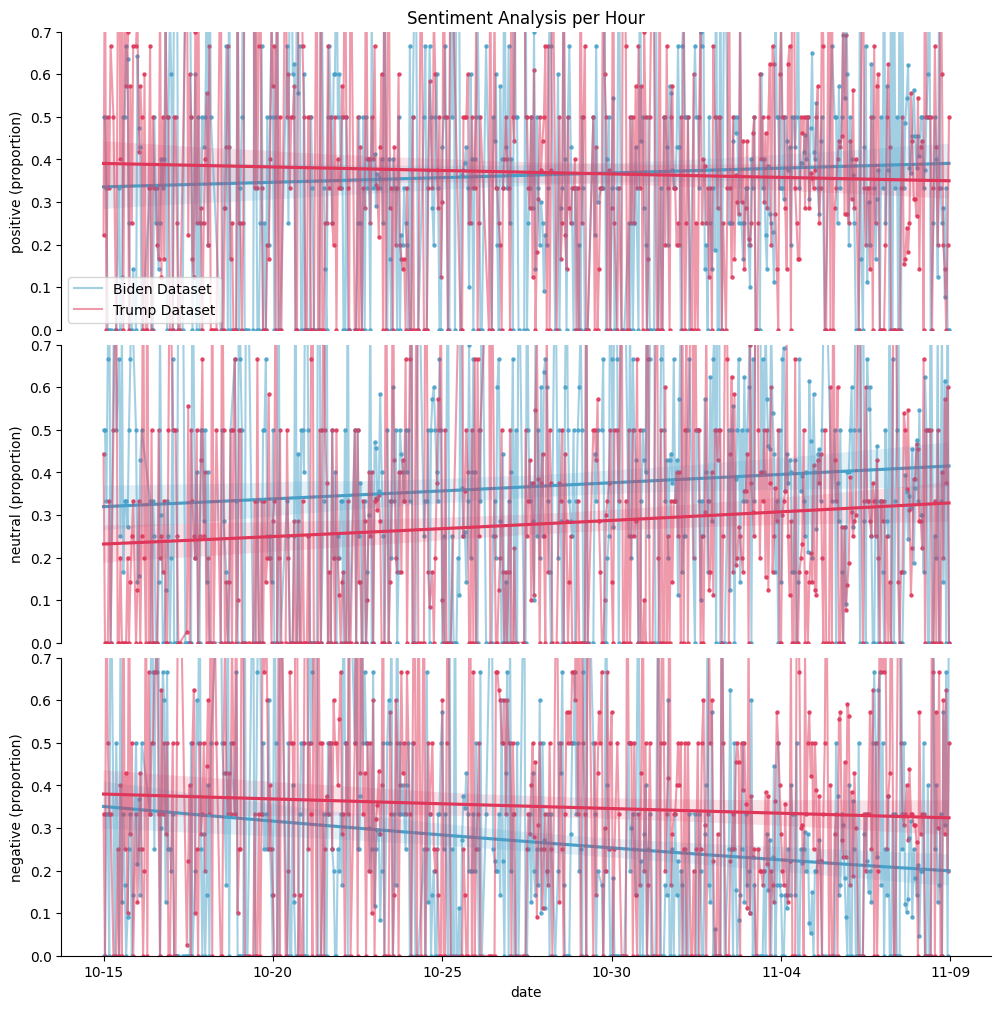

In [41]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 05-08"""
    return dates.num2date(x).strftime('%m-%d')

fig, ax=plt.subplots(3,1, figsize=(12,12), gridspec_kw={'hspace':0.05})

# Plot
lineax=ax[0]
lineax.set_title('Sentiment Analysis per Hour')
sns.regplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], alpha=0.5, label='Biden Dataset')
sns.regplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], alpha=0.5, label='Trump Dataset')
lineax.xaxis.set_major_formatter(fake_dates)
lineax.set_ylim([0, 0.7])
lineax.set_xlabel('')
lineax.set_ylabel('positive (proportion)')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax1=ax[1]
sns.regplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], alpha=0.5)
lineax1.xaxis.set_major_formatter(fake_dates)
lineax1.set_ylim([0, 0.7])
lineax1.set_xlabel('')
lineax1.set_ylabel('neutral (proportion)')
lineax1.axes.get_xaxis().set_ticks([])
lineax1.spines['right'].set_visible(False)
lineax1.spines['top'].set_visible(False)
lineax1.spines['bottom'].set_visible(False)

lineax2=ax[2]
sns.regplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], alpha=0.5)
lineax2.xaxis.set_major_formatter(fake_dates)
lineax2.set_ylim([0, 0.7])
lineax2.set_ylabel('negative (proportion)')
lineax2.set_xlabel('date')
lineax2.spines['right'].set_visible(False)
lineax2.spines['top'].set_visible(False)

plt.show()

## 元のノートブックにあった日次頻度だと特定州では厳しい↑

#### Updated 5th Nov - Version 28
The above visualisation was generated by first assigning each tweet a "Positive", "Neutral" or "Negative" sentiment then summing those for each day and calculating the proportions for each sentiment group. Then using logistic regression to find the best fit line to better show the sentiment trend overtime. When viewing the results:

The trend over the entire timeframe of the dataset for both presidential candidates is an increasing "Positive" and "Neutral" sentiment, with reducing negative sentiment.

However interesting developments occured as we approached and subsequent to election day, where we see "Positive" sentiment increase quicker for the democratic candidate over the republican where we see a noticeable gap develop in the logistic regression lines.

Moving onto the "Neutral" sentiment, the differences between two candidates remain largely steady until there is a noticable blip on election day where the gap briefly disappears before then returning to the previous steady difference.

Post-election day we see a shape increase in "Negative" sentiment for the republican candidate.

# 移動平均を追加

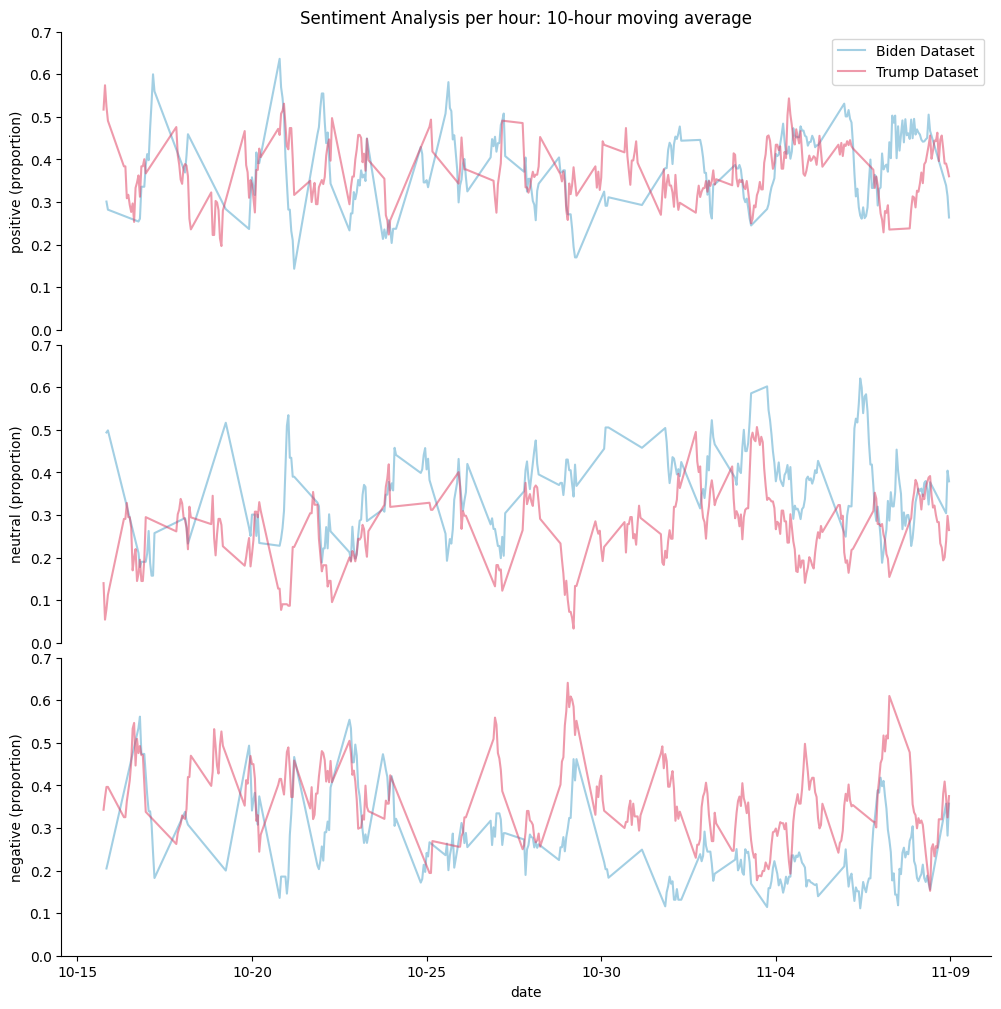

In [42]:
rollw = 10
SentiDat_b['pos_ma'] = SentiDat_b.pos.rolling(rollw).mean()
SentiDat_t['pos_ma'] = SentiDat_t.pos.rolling(rollw).mean()
SentiDat_b['neu_ma'] = SentiDat_b.neu.rolling(rollw).mean()
SentiDat_t['neu_ma'] = SentiDat_t.neu.rolling(rollw).mean()
SentiDat_b['neg_ma'] = SentiDat_b.neg.rolling(rollw).mean()
SentiDat_t['neg_ma'] = SentiDat_t.neg.rolling(rollw).mean()

fig, ax=plt.subplots(3,1, figsize=(12,12), gridspec_kw={'hspace':0.05})

# Plot
lineax=ax[0]
lineax.set_title('Sentiment Analysis per hour: 10-hour moving average')
# sns.regplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos_ma', data=SentiDat_b, ax=lineax, color=barcolors[3], alpha=0.5, label='Biden Dataset')
# sns.regplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos_ma', data=SentiDat_t, ax=lineax, color=barcolors[6], alpha=0.5, label='Trump Dataset')
lineax.xaxis.set_major_formatter(fake_dates)
lineax.set_ylim([0, 0.7])
lineax.set_xlabel('')
lineax.set_ylabel('positive (proportion)')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax1=ax[1]
# sns.regplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu_ma', data=SentiDat_b, ax=lineax1, color=barcolors[3], alpha=0.5)
# sns.regplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu_ma', data=SentiDat_t, ax=lineax1, color=barcolors[6], alpha=0.5)
lineax1.xaxis.set_major_formatter(fake_dates)
lineax1.set_ylim([0, 0.7])
lineax1.set_xlabel('')
lineax1.set_ylabel('neutral (proportion)')
lineax1.axes.get_xaxis().set_ticks([])
lineax1.spines['right'].set_visible(False)
lineax1.spines['top'].set_visible(False)
lineax1.spines['bottom'].set_visible(False)

lineax2=ax[2]
# sns.regplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg_ma', data=SentiDat_b, ax=lineax2, color=barcolors[3], alpha=0.5)
# sns.regplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg_ma', data=SentiDat_t, ax=lineax2, color=barcolors[6], alpha=0.5)
lineax2.xaxis.set_major_formatter(fake_dates)
lineax2.set_ylim([0, 0.7])
lineax2.set_ylabel('negative (proportion)')
lineax2.set_xlabel('date')
lineax2.spines['right'].set_visible(False)
lineax2.spines['top'].set_visible(False)

plt.show()

## Conclusion

#### Updated 5th Nov - Version 28
In this kernel, we performed EDA and sentiment analysis on the [US Election 2020 Tweets dataset](https://www.kaggle.com/manchunhui/us-election-2020-tweets).

There is interest in the US elections from many different countries in the world with tweets from 40 different languages, however with a large proportion of the tweets in English and originating from the US.

The sentiment analysis was performed only on data that had geo-data originating from the "United States of America" to try to ascertain the sentiment in each respective dataset and therefore each presidential candidate. When reviewing sentiment at the state level as we approached the election date a large number of states were trending to a “Positive” sentiment score for the democratic candidate from the previously more “Neutral” sentiment. Whereas most states are still largely “Neutral” for the republican candidate. This trend is correlatable when viewing the sentiment analysis from a date perspective.

I hope you enjoyed reading this kernel, please do not hesitate to comment below if you have any feedback!

# 追加分析

In [43]:
sent_t.created_at_r.min(), sent_t.created_at_r.max()

('2020-10-15 00', '2020-11-08 23')

In [44]:
#選挙直前2週間
sent_t_=sent_t.loc[(sent_t.created_at_r>='2020-10-21 01') & (sent_t.created_at_r<='2020-11-03 23') & (sent_t.state!='Guam')]
sent_b_=sent_b.loc[(sent_b.created_at_r>='2020-10-21 01') & (sent_b.created_at_r<='2020-11-03 23') & (sent_t.state!='Guam')]

In [45]:
stack_t_sum=sent_t_.groupby(['state','sentiment'])['tweet'].count().reset_index()
stack_b_sum=sent_b_.groupby(['state','sentiment'])['tweet'].count().reset_index()

In [46]:
print(stack_t_sum.shape, stack_b_sum.shape)

(153, 3) (153, 3)


In [47]:
stack_sum = pd.merge(stack_t_sum, stack_b_sum, on=['state', 'sentiment'], suffixes=['_t', '_b'])
stack_sum.shape

(153, 4)

In [48]:
sentiments_weights = pd.DataFrame({'sentiment':['pos','neu','neg'], 'weights':[1,0,-1], 'weights2':[1,0,1]})
sentiments_weights

sentiment  weights  weights2
0       pos        1         1
1       neu        0         0
2       neg       -1         1

In [49]:
stack_sum2 = pd.merge(stack_sum, sentiments_weights, how='left')
stack_sum2.shape

(153, 6)

In [50]:
stack_sum3 = stack_sum2.groupby(['state'])[['tweet_t', 'tweet_b']].sum().reset_index()
stack_sum3

state  tweet_t  tweet_b
0                Alabama      394      108
1                 Alaska      134       80
2                Arizona     1579      429
3               Arkansas      338       45
4             California    16057     3076
5               Colorado     1890      317
6            Connecticut      667      136
7               Delaware      118       43
8   District of Columbia     4999      773
9                Florida     9126     1783
10               Georgia     1398      386
11                Hawaii      374      106
12                 Idaho      330       54
13              Illinois     3517      669
14               Indiana      647      145
15                  Iowa      445       64
16                Kansas      495      126
17              Kentucky      728      169
18             Louisiana      592      125
19                 Maine      277       49
20              Maryland     1187      239
21         Massachusetts     2767      414
22              Michigan     1570      406
23             Minnesota     1037      226
24           Mississippi      132       43
25              Missouri     1250      219
26               Montana       99       51
27              Nebraska      189       45
28                Nevada     1184      284
29         New Hampshire      149       53
30            New Jersey     2818      470
31            New Mexico      251       48
32              New York    11806     2453
33        North Carolina     1829      406
34          North Dakota      256       29
35                  Ohio     1905      716
36              Oklahoma      448      108
37                Oregon     1709      316
38          Pennsylvania     3881      740
39          Rhode Island      164       38
40        South Carolina      627      175
41          South Dakota       30       12
42             Tennessee     1239      266
43                 Texas     8499     1785
44                  Utah      496      153
45               Vermont      530       21
46              Virginia     1145      272
47            Washington     1461      240
48         West Virginia      148       47
49             Wisconsin      725      214
50               Wyoming      146       38

In [51]:
stack_sum2 = pd.merge(stack_sum2, stack_sum3, how = 'left', on='state', suffixes=['','_total'])
stack_sum2

state sentiment  tweet_t  tweet_b  weights  weights2  tweet_t_total  \
0      Alabama       neg      125       27       -1         1            394   
1      Alabama       neu      125       40        0         0            394   
2      Alabama       pos      144       41        1         1            394   
3       Alaska       neg       51       31       -1         1            134   
4       Alaska       neu       37       20        0         0            134   
..         ...       ...      ...      ...      ...       ...            ...   
148  Wisconsin       neu      226       73        0         0            725   
149  Wisconsin       pos      259       94        1         1            725   
150    Wyoming       neg       46       16       -1         1            146   
151    Wyoming       neu       47       12        0         0            146   
152    Wyoming       pos       53       10        1         1            146   

     tweet_b_total  
0              108  
1              108  
2              108  
3               80  
4               80  
..             ...  
148            214  
149            214  
150             38  
151             38  
152             38  

[153 rows x 8 columns]

In [52]:
#これを回すと各感情の構成割合に、コメントアウトなら各感情のtweet絶対数になる
#stack_sum2['tweet_t'] = stack_sum2['tweet_t']/stack_sum2['tweet_t_total']
#stack_sum2['tweet_b'] = stack_sum2['tweet_b']/stack_sum2['tweet_b_total']
#stack_sum2.head()

In [53]:
stack_sum2['tweet_diff'] = (stack_sum2['tweet_t'] - stack_sum2['tweet_b']) * stack_sum2['weights']
stack_sum2['tweet_posneg_total'] = (stack_sum2['tweet_t'] + stack_sum2['tweet_b']) * stack_sum2['weights2']

stack_sum2

state sentiment  tweet_t  tweet_b  weights  weights2  tweet_t_total  \
0      Alabama       neg      125       27       -1         1            394   
1      Alabama       neu      125       40        0         0            394   
2      Alabama       pos      144       41        1         1            394   
3       Alaska       neg       51       31       -1         1            134   
4       Alaska       neu       37       20        0         0            134   
..         ...       ...      ...      ...      ...       ...            ...   
148  Wisconsin       neu      226       73        0         0            725   
149  Wisconsin       pos      259       94        1         1            725   
150    Wyoming       neg       46       16       -1         1            146   
151    Wyoming       neu       47       12        0         0            146   
152    Wyoming       pos       53       10        1         1            146   

     tweet_b_total  tweet_diff  tweet_posneg_total  
0              108         -98                 152  
1              108           0                   0  
2              108         103                 185  
3               80         -20                  82  
4               80           0                   0  
..             ...         ...                 ...  
148            214           0                   0  
149            214         165                 353  
150             38         -30                  62  
151             38           0                   0  
152             38          43                  63  

[153 rows x 10 columns]

In [54]:
sentiment_state=stack_sum2.groupby(['state'])[['tweet_diff','tweet_posneg_total']].sum().reset_index()
sentiment_state['pred'] = sentiment_state['tweet_diff'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
sentiment_state

state  tweet_diff  tweet_posneg_total  pred
0                Alabama           5                 337     1
1                 Alaska          -3                 157    -1
2                Arizona         107                1433     1
3               Arkansas          32                 212     1
4             California        -224               13138    -1
5               Colorado        -222                1466    -1
6            Connecticut         -15                 441    -1
7               Delaware          -8                 102    -1
8   District of Columbia        -198                3650    -1
9                Florida         286                6898     1
10               Georgia          37                1145     1
11                Hawaii          20                 332     1
12                 Idaho           6                 272     1
13              Illinois        -167                3005    -1
14               Indiana         -10                 482    -1
15                  Iowa         -13                 337    -1
16                Kansas           3                 411     1
17              Kentucky          49                 615     1
18             Louisiana          18                 486     1
19                 Maine           4                 202     1
20              Maryland          -8                 974    -1
21         Massachusetts        -134                2376    -1
22              Michigan         -22                1364    -1
23             Minnesota         -93                 861    -1
24           Mississippi          35                 123     1
25              Missouri         -33                1015    -1
26               Montana          -6                 106    -1
27              Nebraska          24                 148     1
28                Nevada          16                 980     1
29         New Hampshire           9                 137     1
30            New Jersey         -27                2029    -1
31            New Mexico           2                 202     1
32              New York        -534                9288    -1
33        North Carolina          90                1460     1
34          North Dakota         -33                 213    -1
35                  Ohio         -82                1680    -1
36              Oklahoma         -27                 389    -1
37                Oregon          74                1468     1
38          Pennsylvania           4                3260     1
39          Rhode Island          -2                 120    -1
40        South Carolina         -69                 577    -1
41          South Dakota          -1                  31    -1
42             Tennessee          15                 987     1
43                 Texas         -95                6635    -1
44                  Utah          32                 334     1
45               Vermont        -106                 426    -1
46              Virginia        -114                1002    -1
47            Washington          10                1224     1
48         West Virginia         -10                 122    -1
49             Wisconsin         -28                 640    -1
50               Wyoming          13                 125     1

In [55]:
data_elct2020 = {
    "state": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
        "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
        "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
        "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ],
    "true": [
        1,
        1,
        -1,
        1,
        -1,
        -1,
        -1,
        -1,
        -1,
        1,
        -1,
        -1,
        1,
        -1,
        1,
        1,
        1,
        1,
        1,
        -1,
        -1,
        -1,
        -1,
        -1,
        1,
        1,
        1,
        1,
        -1,
        -1,
        -1,
        -1,
        -1,
        1,
        1,
        1,
        1,
        -1,
        -1,
        -1,
        1,
        1,
        1,
        1,
        1,
        -1,
        -1,
        -1,
        1,
        -1,
        1,
        ],
    "num_ev": [
        9, 3, 11, 6, 55, 9, 7, 3, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10, 3,
        5, 6, 4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3
    ],
    "type" :[
        'SR',
        'SR',
        'LD',
        'SR',
        'SD',
        'SD',
        'SD',
        'SD',
        'SD',
        'TU',
        'TU',
        'SD',
        'SR',
        'SD',
        'SR',
        'TU',
        'SR',
        'SR',
        'SR',
        'SD',
        'SD',
        'SD',
        'LD',
        'SD',
        'SR',
        'SR',
        'SR',
        'SR',
        'LD',
        'SD',
        'SD',
        'SD',
        'SD',
        'TU',
        'SR',
        'TU',
        'SR',
        'SD',
        'LD',
        'SD',
        'SR',
        'SR',
        'SR',
        'TU',
        'SR',
        'SD',
        'SD',
        'SD',
        'SR',
        'LD',
        'SR',
    ]
}

df_elct2020 = pd.DataFrame(data_elct2020)
print(df_elct2020)

                   state  true  num_ev type
0                Alabama     1       9   SR
1                 Alaska     1       3   SR
2                Arizona    -1      11   LD
3               Arkansas     1       6   SR
4             California    -1      55   SD
5               Colorado    -1       9   SD
6            Connecticut    -1       7   SD
7               Delaware    -1       3   SD
8   District of Columbia    -1       3   SD
9                Florida     1      29   TU
10               Georgia    -1      16   TU
11                Hawaii    -1       4   SD
12                 Idaho     1       4   SR
13              Illinois    -1      20   SD
14               Indiana     1      11   SR
15                  Iowa     1       6   TU
16                Kansas     1       6   SR
17              Kentucky     1       8   SR
18             Louisiana     1       8   SR
19                 Maine    -1       4   SD
20              Maryland    -1      10   SD
21         Massachusetts    -1  

In [56]:
#選挙結果
df_elct2020.groupby(['true'])['num_ev'].sum().reset_index()

true  num_ev
0    -1     306
1     1     232

In [57]:
sentiment_state = pd.merge(sentiment_state, df_elct2020, how='left')
sentiment_state['tweet_diff_ratio'] = sentiment_state['tweet_diff']/sentiment_state['tweet_posneg_total']
sentiment_state

state  tweet_diff  tweet_posneg_total  pred  true  num_ev  \
0                Alabama           5                 337     1     1       9   
1                 Alaska          -3                 157    -1     1       3   
2                Arizona         107                1433     1    -1      11   
3               Arkansas          32                 212     1     1       6   
4             California        -224               13138    -1    -1      55   
5               Colorado        -222                1466    -1    -1       9   
6            Connecticut         -15                 441    -1    -1       7   
7               Delaware          -8                 102    -1    -1       3   
8   District of Columbia        -198                3650    -1    -1       3   
9                Florida         286                6898     1     1      29   
10               Georgia          37                1145     1    -1      16   
11                Hawaii          20                 332     1    -1       4   
12                 Idaho           6                 272     1     1       4   
13              Illinois        -167                3005    -1    -1      20   
14               Indiana         -10                 482    -1     1      11   
15                  Iowa         -13                 337    -1     1       6   
16                Kansas           3                 411     1     1       6   
17              Kentucky          49                 615     1     1       8   
18             Louisiana          18                 486     1     1       8   
19                 Maine           4                 202     1    -1       4   
20              Maryland          -8                 974    -1    -1      10   
21         Massachusetts        -134                2376    -1    -1      11   
22              Michigan         -22                1364    -1    -1      16   
23             Minnesota         -93                 861    -1    -1      10   
24           Mississippi          35                 123     1     1       6   
25              Missouri         -33                1015    -1     1      10   
26               Montana          -6                 106    -1     1       3   
27              Nebraska          24                 148     1     1       5   
28                Nevada          16                 980     1    -1       6   
29         New Hampshire           9                 137     1    -1       4   
30            New Jersey         -27                2029    -1    -1      14   
31            New Mexico           2                 202     1    -1       5   
32              New York        -534                9288    -1    -1      29   
33        North Carolina          90                1460     1     1      15   
34          North Dakota         -33                 213    -1     1       3   
35                  Ohio         -82                1680    -1     1      18   
36              Oklahoma         -27                 389    -1     1       7   
37                Oregon          74                1468     1    -1       7   
38          Pennsylvania           4                3260     1    -1      20   
39          Rhode Island          -2                 120    -1    -1       4   
40        South Carolina         -69                 577    -1     1       9   
41          South Dakota          -1                  31    -1     1       3   
42             Tennessee          15                 987     1     1      11   
43                 Texas         -95                6635    -1     1      38   
44                  Utah          32                 334     1     1       6   
45               Vermont        -106                 426    -1    -1       3   
46              Virginia        -114                1002    -1    -1      13   
47            Washington          10                1224     1    -1      12   
48         West Virginia         -10                 122    -1     1       5   
49             Wisc

In [58]:
states_gekisen = ['Michigan','Wisconsin','Arizona','Florida','North Carolina','Pennsylvania']

In [59]:
sentiment_state.groupby(['pred','true'])['state'].count().reset_index()

pred  true  state
0    -1    -1     16
1    -1     1     12
2     1    -1     10
3     1     1     13

In [114]:
sentiment_state.groupby(['pred','true'])['num_ev'].sum().reset_index()

pred  true  num_ev
0    -1    -1     217
1    -1     1     116
2     1    -1      89
3     1     1     116

In [60]:
sentiment_state.groupby(['type','pred','true'])['state'].count().reset_index()

type  pred  true  state
0   LD    -1    -1      2
1   LD     1    -1      3
2   SD    -1    -1     14
3   SD     1    -1      6
4   SR    -1     1      9
5   SR     1     1     11
6   TU    -1     1      3
7   TU     1    -1      1
8   TU     1     1      2

In [61]:
sentiment_state.groupby(['pred','true'])['tweet_diff'].mean()

pred  true
-1    -1     -118.875000
       1      -31.833333
 1    -1       28.300000
       1       46.769231
Name: tweet_diff, dtype: float64

In [62]:
sentiment_state.groupby(['pred'])['num_ev'].sum().reset_index()

pred  num_ev
0    -1     333
1     1     205

In [63]:
sentiment_state.loc[sentiment_state.state.isin(states_gekisen)].groupby(['pred','true'])['state'].count().reset_index()

pred  true  state
0    -1    -1      2
1     1    -1      2
2     1     1      2

In [64]:
sentiment_state.sort_values('tweet_diff')

state  tweet_diff  tweet_posneg_total  pred  true  num_ev  \
32              New York        -534                9288    -1    -1      29   
4             California        -224               13138    -1    -1      55   
5               Colorado        -222                1466    -1    -1       9   
8   District of Columbia        -198                3650    -1    -1       3   
13              Illinois        -167                3005    -1    -1      20   
21         Massachusetts        -134                2376    -1    -1      11   
46              Virginia        -114                1002    -1    -1      13   
45               Vermont        -106                 426    -1    -1       3   
43                 Texas         -95                6635    -1     1      38   
23             Minnesota         -93                 861    -1    -1      10   
35                  Ohio         -82                1680    -1     1      18   
40        South Carolina         -69                 577    -1     1       9   
34          North Dakota         -33                 213    -1     1       3   
25              Missouri         -33                1015    -1     1      10   
49             Wisconsin         -28                 640    -1    -1      10   
36              Oklahoma         -27                 389    -1     1       7   
30            New Jersey         -27                2029    -1    -1      14   
22              Michigan         -22                1364    -1    -1      16   
6            Connecticut         -15                 441    -1    -1       7   
15                  Iowa         -13                 337    -1     1       6   
14               Indiana         -10                 482    -1     1      11   
48         West Virginia         -10                 122    -1     1       5   
20              Maryland          -8                 974    -1    -1      10   
7               Delaware          -8                 102    -1    -1       3   
26               Montana          -6                 106    -1     1       3   
1                 Alaska          -3                 157    -1     1       3   
39          Rhode Island          -2                 120    -1    -1       4   
41          South Dakota          -1                  31    -1     1       3   
31            New Mexico           2                 202     1    -1       5   
16                Kansas           3                 411     1     1       6   
38          Pennsylvania           4                3260     1    -1      20   
19                 Maine           4                 202     1    -1       4   
0                Alabama           5                 337     1     1       9   
12                 Idaho           6                 272     1     1       4   
29         New Hampshire           9                 137     1    -1       4   
47            Washington          10                1224     1    -1      12   
50               Wyoming          13                 125     1     1       3   
42             Tennessee          15                 987     1     1      11   
28                Nevada          16                 980     1    -1       6   
18             Louisiana          18                 486     1     1       8   
11                Hawaii          20                 332     1    -1       4   
27              Nebraska          24                 148     1     1       5   
44                  Utah          32                 334     1     1       6   
3               Arkansas          32                 212     1     1       6   
24           Mississippi          35                 123     1     1       6   
10               Georgia          37                1145     1    -1      16   
17              Kentucky          49                 615     1     1       8   
37                Oregon          74                1468     1    -1       7   
33        North Carolina          90                1460     1     1      15   
2                Ar

In [107]:
sentiment_state['pred_map'] = sentiment_state['pred']
sentiment_state.loc[sentiment_state['type'].str.contains('L'),'pred_map'] = sentiment_state.loc[sentiment_state['type'].str.contains('L'),'pred_map']/2
sentiment_state.loc[sentiment_state['type']=='TU','pred_map'] = sentiment_state.loc[sentiment_state['type']=='TU','pred_map']/2

sentiment_state['true_map'] = sentiment_state['true']
sentiment_state.loc[sentiment_state['type'].str.contains('L'),'true_map'] = sentiment_state.loc[sentiment_state['type'].str.contains('L'),'true_map']/2
sentiment_state.loc[sentiment_state['type']=='TU','true_map'] = sentiment_state.loc[sentiment_state['type']=='TU','true_map']/2

In [74]:
# import the folium library
import folium

In [76]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data"
)
state_geo = f"{url}/us-states.json"

In [110]:
# initialize the map and store it in a m object
m = folium.Map(location=[40, -95], zoom_start=4)
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=sentiment_state,
    columns=['state', 'true_map'],
    key_on='feature.properties.name',
    fill_color='RdBu_r', # 1:Trump, -1:Biden
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name='vote results',
).add_to(m)

folium.LayerControl().add_to(m)

m

In [109]:
# initialize the map and store it in a m object
m = folium.Map(location=[40, -95], zoom_start=4)
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=sentiment_state,
    columns=['state', 'pred_map'],
    key_on='feature.properties.name',
    fill_color='RdBu_r', # 1:Trump, -1:Biden
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name='prediction',
).add_to(m)

folium.LayerControl().add_to(m)

m

# トピック探索

In [65]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [66]:
def my_topicmodel(sent_x, num_topics=15, topn=10, no_below=None, no_above=0.3, num_sampled=3000, lowest_num_tokens=10):
    random.seed(42)
    def clean3(sent):
        filtered_sent=""
        stopwords = nltk.corpus.stopwords.words('english')
        wnl = nltk.stem.WordNetLemmatizer()
        sent = (unicodedata.normalize('NFKD', sent)
                .encode('ascii', 'ignore')
                    .decode('utf-8', 'ignore')
                .lower())
        sent = re.sub(r'.*biden|donald.*|\(|\)|#.+|https.+|[^(a-zA-Z)\s]','',sent)
        # sent = re.findall(r'#.+', sent)[0]
        words=sent.split()
        for word in words:
            if word not in stopwords:
                # filtered_sent=filtered_sent+' '+wnl.lemmatize(word)
                filtered_sent=filtered_sent+' '+word
        return filtered_sent

    sent_t_cleaned3 = sent_x['tweet'].apply(clean3)

    sent_t_cleaned3 = pd.DataFrame(sent_t_cleaned3)
    sent_t_cleaned3['len_cleaned_tweet'] = sent_t_cleaned3['tweet'].apply(lambda x:len(word_tokenize(x.lower())))
    sent_t_cleaned3_long = sent_t_cleaned3[sent_t_cleaned3.len_cleaned_tweet >= lowest_num_tokens]

    text_data = sent_t_cleaned3_long.tweet.iloc[random.sample(range(len(sent_t_cleaned3_long)), num_sampled)]

    # Tokenization and preprocessing
    stop_words = set(stopwords.words('english'))
    tokenized_data = [word_tokenize(text.lower()) for text in text_data]
    filtered_data = [[word for word in text if word not in stop_words] for text in tokenized_data]

    # Creating a dictionary representation of the documents
    dictionary = corpora.Dictionary(filtered_data)
    if not no_below:
        no_below = int(0.01*num_sampled)
    dictionary.filter_extremes(no_below=no_below,no_above=no_above)

    # Converting the list of documents into a Document-Term Matrix using dictionary prepared above
    corpus = [dictionary.doc2bow(text) for text in filtered_data]

    # LDA model training
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Displaying the topics
    for idx, topic in lda_model.print_topics(-1):
        print("Topic {}:".format(idx))
        print(topic)
        print("\n")

    # Alternatively, you can store the topics in a DataFrame
    words = []
    for t in range(num_topics):
        word=[]
        for i, prob in lda_model.get_topic_terms(t, topn=topn):
            word.append(dictionary.id2token[int(i)])
        words.append(word)
    df = pd.DataFrame(words)
    return df

In [67]:
my_topicmodel(sent_b)

Topic 0:
0.112*"hes" + 0.080*"get" + 0.048*"things" + 0.044*"years" + 0.042*"new" + 0.040*"trumps" + 0.040*"done" + 0.038*"like" + 0.038*"next" + 0.037*"going"


Topic 1:
0.443*"trump" + 0.046*"voting" + 0.045*"day" + 0.043*"money" + 0.037*"election" + 0.033*"must" + 0.029*"supporters" + 0.024*"watch" + 0.018*"youre" + 0.018*"republicans"


Topic 2:
0.148*"president" + 0.054*"make" + 0.052*"work" + 0.041*"tax" + 0.039*"us" + 0.033*"job" + 0.033*"american" + 0.033*"america" + 0.030*"kamalaharris" + 0.027*"china"


Topic 3:
0.202*"de" + 0.142*"la" + 0.098*"en" + 0.082*"life" + 0.077*"que" + 0.063*"el" + 0.052*"might" + 0.050*"los" + 0.042*"se" + 0.035*"save"


Topic 4:
0.074*"presidential" + 0.071*"debate" + 0.070*"na" + 0.056*"tonight" + 0.051*"thing" + 0.049*"candidate" + 0.048*"away" + 0.045*"thank" + 0.041*"hey" + 0.040*"final"


Topic 5:
0.223*"vote" + 0.070*"black" + 0.062*"amp" + 0.054*"im" + 0.045*"care" + 0.044*"plan" + 0.042*"real" + 0.041*"go" + 0.030*"wants" + 0.028*"party"



0       1        2          3         4          5           6  \
0            hes     get   things      years       new     trumps        done   
1          trump  voting      day      money  election       must  supporters   
2      president    make     work        tax        us        job    american   
3             de      la       en       life       que         el       might   
4   presidential  debate       na    tonight     thing  candidate        away   
5           vote   black      amp         im      care       plan        real   
6           time  harris     like        one     every        big       needs   
7          votes   white    house  electoral   million     voters      around   
8            amp   count  ballots       wont       gop       lies        left   
9       election   still     says        see     right      youre     america   
10         would      us      win     please  election      could        know   
11        states     joe     dont       cant    united      taxes           k   
12          need    good    think      never       son        get      doesnt   
13           amp      pa    media         mi     video         wi  corruption   
14        people    even     well      didnt      know       said       first   

           7             8            9  
0       like          next        going  
1      watch         youre  republicans  
2    america  kamalaharris        china  
3        los            se         save  
4      thank           hey        final  
5         go         wants        party  
6       many          much   presidency  
7       keep     president         week  
8        lot          take         long  
9        way          stop          may  
10    change       country        night  
11     since        really       anyone  
12      sure        family        voted  
13      wins             w           us  
14  campaign           say         like

In [68]:
my_topicmodel(sent_t)

Topic 0:
0.074*"get" + 0.072*"trump" + 0.056*"right" + 0.049*"us" + 0.041*"left" + 0.038*"news" + 0.038*"back" + 0.037*"election" + 0.034*"fraud" + 0.033*"big"


Topic 1:
0.171*"real" + 0.088*"trumps" + 0.081*"trump" + 0.081*"covid" + 0.056*"got" + 0.049*"voters" + 0.035*"already" + 0.033*"well" + 0.032*"harristosaveamerica" + 0.032*"get"


Topic 2:
0.222*"vote" + 0.073*"hes" + 0.068*"trump" + 0.057*"supporters" + 0.053*"love" + 0.051*"family" + 0.047*"look" + 0.044*"watch" + 0.032*"trying" + 0.029*"theyre"


Topic 3:
0.251*"trump" + 0.077*"votes" + 0.055*"going" + 0.040*"campaign" + 0.035*"court" + 0.033*"democrats" + 0.031*"done" + 0.031*"count" + 0.030*"could" + 0.028*"states"


Topic 4:
0.276*"amp" + 0.117*"care" + 0.069*"every" + 0.055*"didnt" + 0.055*"person" + 0.049*"black" + 0.045*"meant" + 0.043*"millions" + 0.042*"read" + 0.041*"retweet"


Topic 5:
0.085*"white" + 0.066*"house" + 0.061*"state" + 0.056*"states" + 0.050*"believe" + 0.045*"matter" + 0.045*"wait" + 0.044*"call" +

0       1         2           3        4          5        6  \
0         get   trump     right          us     left       news     back   
1        real  trumps     trump       covid      got     voters  already   
2        vote     hes     trump  supporters     love     family     look   
3       trump   votes     going    campaign    court  democrats     done   
4         amp    care     every       didnt   person      black    meant   
5       white   house     state      states  believe     matter     wait   
6         amp     say     years       great    would       four      put   
7        like    good       man         yes      end        men     feel   
8        dont  please      take         let    think       want     away   
9   president   trump  american      better      cnn  americans    potus   
10        one    many    doesnt       money     even       best     cant   
11         de      la       que          en       el        los    trump   
12     people      us       amp        stop    china    support  corrupt   
13   election  harris   america         day       im      never     time   
14       last     gop      know        vote     year       said       go   

           7                    8          9  
0   election                fraud        big  
1       well  harristosaveamerica        get  
2      watch               trying     theyre  
3      count                could     states  
4   millions                 read    retweet  
5       call                truth       also  
6        may                 work    country  
7     people                 evil      thats  
8   election                 need        day  
9        via                 fall     people  
10      know                 ever        bad  
11        un                   se  political  
12    racist                  lot       give  
13   million                first    history  
14       new               medias       less

In [69]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

In [70]:
num_sampled = 3000

In [71]:
from bertopic import BERTopic
docs=sent_t.tweet.iloc[random.sample(range(len(sent_t)), num_sampled)]
topic_model = BERTopic(language='english', calculate_probabilities=True, verbose=True, nr_topics='20')
topics, probs = topic_model.fit_transform(docs)

2024-06-04 05:14:50,336 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2024-06-04 05:16:57,013 - BERTopic - Embedding - Completed ✓
2024-06-04 05:16:57,015 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-04 05:17:25,061 - BERTopic - Dimensionality - Completed ✓
2024-06-04 05:17:25,064 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-04 05:17:25,293 - BERTopic - Cluster - Completed ✓
2024-06-04 05:17:25,295 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-04 05:17:25,454 - BERTopic - Representation - Completed ✓
2024-06-04 05:17:25,457 - BERTopic - Topic reduction - Reducing number of topics
2024-06-04 05:17:25,604 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


In [72]:
topic_model.get_topic_info()

Topic  Count                Name  \
0      0   2913  0_trump_the_to_and   
1      1     87       1_de_la_en_el   

                                      Representation  \
0  [trump, the, to, and, is, of, in, for, you, that]   
1     [de, la, en, el, que, trump, se, del, es, por]   

                                 Representative_Docs  
0  [well okay as you likely have been seeing ever...  
1  [Estas son las elecciones más importantes  en ...

In [73]:
docs=sent_b.tweet.iloc[random.sample(range(len(sent_b)), num_sampled)]
topic_model = BERTopic(language='english', calculate_probabilities=True, verbose=True, nr_topics='20')
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

2024-06-04 05:17:25,694 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2024-06-04 05:19:55,563 - BERTopic - Embedding - Completed ✓
2024-06-04 05:19:55,566 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-04 05:20:14,522 - BERTopic - Dimensionality - Completed ✓
2024-06-04 05:20:14,524 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-04 05:20:15,065 - BERTopic - Cluster - Completed ✓
2024-06-04 05:20:15,066 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-04 05:20:15,248 - BERTopic - Representation - Completed ✓
2024-06-04 05:20:15,250 - BERTopic - Topic reduction - Reducing number of topics
2024-06-04 05:20:15,429 - BERTopic - Topic reduction - Reduced number of topics from 42 to 39


Topic  Count                                               Name  \
0      -1   1139                           -1_the_to_biden_joebiden   
1       0    236                    0_biden_realdonaldtrump_you_the   
2       1    187      1_kamalaharris_joebiden_kamala_kamalaharrisvp   
3       2    177          2_biden_vote_election2020_bidenharris2020   
4       3    123                                3_biden_trump_to_is   
5       4    107                           4_joebiden_is_cages_blah   
6       5     78                     5_covid19_covid_coronavirus_we   
7       6     76                  6_hunter_fbi_hunterbiden_business   
8       7     74                             7_oil_tax_industry_and   
9       8     63                            8_joe_joebiden_biden_is   
10      9     55                                      9_de_el_en_la   
11     10     50                       10_harris_cannabis_biden_for   
12     11     47                       11_joebiden_president_the_is   
13     12     42                12_realdonaldtrump_joebiden_you_kid   
14     13     36                  13_michigan_wisconsin_state_votes   
15     14     35                             14_georgia_votes_in_nv   
16     15     34         15_racist_black_predators_blacklivesmatter   
17     16     33                            16_if_russia_term_video   
18     17     32                       17_pennsylvania_pa_votes_win   
19     18     32  18_election2020_joebiden_donaldtrump_electionr...   
20     19     32                         19_china_chinese_the_trump   
21     20     28                            20_texas_sign_bus_flags   
22     21     24                         21_god_catholic_bible_anti   
23     22     21       22_bidenharis2020_bidenharris2020_biden_code   
24     23     21                         23_for_vote_joebiden_voted   
25     24     20          24_joebiden_chelseahandler_zionist_person   
26     25     19  25_he_moderator_debates2020_presidentialdebate...   
27     26     19                     26_win_prediction_election_won   
28     27     19       27_debates2020_debatetonight_joebiden_hitler   
29     28     18  28_trumpvirus_trumpisalaughingstock_ditchmosco...   
30     29     16                       29_florida_in_miamidade_both   
31     30     15                    30_took_governments_cash_health   
32     31     15                            31_georgia_in_votes_now   
33     32     14                         32_le_lecteurs_grands_pour   
34     33     14              33_wtpblue_wtpsenate_wtpbiden_demcast   
35     34     13  34_christoperandersonphoto_joebiden_electionni...   
36     35     12        35_disgusting_mikebloomberg_her_journalists   
37     36     12                           36_arizona_az_foxnews_ap   
38     37     12     37_hunterbiden_hunterbidenlaptop_addict_hunter   

                                       Representation  \
0   [the, to, biden, joebiden, and, is, trump, of,...   
1   [biden, realdonaldtrump, you, the, trump, is, ...   
2   [kamalaharris, joebiden, kamala, kamalaharrisv...   
3   [biden, vote, election2020, bidenharris2020, f...   
4   [biden, trump, to, is, nets, fdt, wager, world...   
5   [joebiden, is, cages, blah, built, wins, the, ...   
6   [covid19, covid, coronavirus, we, to, plan, pa...   
7   [hunter, fbi, hunterbiden, business, laptop, h...   
8   [oil, tax, industry, and, plan, fracking, soci...   
9   [joe, joebiden, biden, is, bidenharris2020, th...   
10  [de, el, en, la, que, por, elecciones2020, es,...   
11  [harris, cannabis, biden, for, to, there, is, ...   
12  [joebiden, president, the, is, of, to, we, wha...   
13  [realdonaldtrump, joebiden, you, kid, who, fre...   
14  [michigan, wisconsin, state, votes, recount, s...   
15  [georgia, votes, in, nv, biden, to, senate, no...   
16  [racist, black, predators, blacklivesmatter, o...   
17  [if, russia, term, video, httpstcoon9wg5rovf, ...   
18  [pennsylvania, pa, votes, win, in, to, ballots...   
19  [election2020, joeb